In [1]:
# Install required libraries
!pip install shap lime scikit-learn tensorflow pandas numpy matplotlib seaborn plotly kaggle --quiet

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import IsolationForest, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Causal & Explainability
import shap

print("✅ All libraries loaded successfully!")
print(f"TensorFlow version: {tf.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✅ All libraries loaded successfully!
TensorFlow version: 2.19.0


In [2]:
# ============================================================
# OPTION A: Upload your own business CSV file
# ============================================================
from google.colab import files
import io

print("=" * 60)
print("REVENUE LEAKAGE DETECTION SYSTEM")
print("=" * 60)
print("\nChoose data source:")
print("1 - Upload your own CSV file")
print("2 - Use sample Kaggle-style dataset (auto-generated)")

choice = input("\nEnter choice (1 or 2): ").strip()

if choice == "1":
    print("\n📂 Please upload your CSV file...")
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    df_raw = pd.read_csv(io.BytesIO(uploaded[file_name]))
    print(f"\n✅ File '{file_name}' loaded successfully!")
    print(f"Shape: {df_raw.shape}")
    print(f"\nColumns found: {list(df_raw.columns)}")
    df_raw.head()

else:
    print("\n📊 Generating synthetic business revenue dataset...")

    np.random.seed(42)
    n = 5000

    df_raw = pd.DataFrame({
        'transaction_id':      range(1, n+1),
        'customer_id':         np.random.randint(1000, 9999, n),
        'invoice_amount':      np.round(np.random.exponential(500, n) + 50, 2),
        'payment_received':    None,
        'discount_applied':    np.round(np.random.uniform(0, 0.3, n), 2),
        'contract_price':      None,
        'billing_date':        pd.date_range('2022-01-01', periods=n, freq='H'),
        'payment_date':        None,
        'product_category':    np.random.choice(['SaaS', 'Hardware', 'Service', 'License'], n),
        'region':              np.random.choice(['North', 'South', 'East', 'West', 'International'], n),
        'sales_rep':           np.random.choice([f'REP_{i}' for i in range(1, 21)], n),
        'customer_segment':    np.random.choice(['Enterprise', 'SMB', 'Startup'], n),
        'contract_duration':   np.random.choice([1, 6, 12, 24, 36], n),
        'num_units':           np.random.randint(1, 100, n),
        'unit_price':          np.round(np.random.uniform(10, 200, n), 2),
        'tax_applied':         np.round(np.random.uniform(0, 0.18, n), 2),
        'chargeback':          np.random.choice([0, 1], n, p=[0.92, 0.08]),
        'late_payment_flag':   np.random.choice([0, 1], n, p=[0.75, 0.25]),
        'manual_override':     np.random.choice([0, 1], n, p=[0.88, 0.12]),
        'billing_errors':      np.random.choice([0, 1, 2, 3], n, p=[0.70, 0.15, 0.10, 0.05]),
    })

    df_raw['contract_price'] = df_raw['invoice_amount'] * np.random.uniform(0.9, 1.1, n)
    df_raw['payment_received'] = df_raw['invoice_amount'] * np.random.uniform(0.5, 1.0, n)
    df_raw['payment_received'] = np.round(df_raw['payment_received'], 2)

    # Inject revenue leakage patterns
    leakage_mask = np.random.choice([0, 1], n, p=[0.75, 0.25])
    df_raw['revenue_leakage'] = 0

    # Pattern 1: Underpayment
    mask1 = (leakage_mask == 1) & (df_raw['payment_received'] < df_raw['invoice_amount'] * 0.9)
    df_raw.loc[mask1, 'revenue_leakage'] = 1

    # Pattern 2: Excessive discount
    mask2 = df_raw['discount_applied'] > 0.25
    df_raw.loc[mask2, 'revenue_leakage'] = 1

    # Pattern 3: Billing errors
    mask3 = df_raw['billing_errors'] >= 2
    df_raw.loc[mask3, 'revenue_leakage'] = 1

    # Pattern 4: Manual override anomalies
    mask4 = (df_raw['manual_override'] == 1) & (df_raw['chargeback'] == 1)
    df_raw.loc[mask4, 'revenue_leakage'] = 1

    df_raw['leakage_amount'] = np.where(
        df_raw['revenue_leakage'] == 1,
        np.round(df_raw['invoice_amount'] - df_raw['payment_received'], 2),
        0
    )

    print(f"✅ Dataset generated! Shape: {df_raw.shape}")
    print(f"Leakage Rate: {df_raw['revenue_leakage'].mean()*100:.1f}%")

print("\n--- First 5 rows ---")
display(df_raw.head())

REVENUE LEAKAGE DETECTION SYSTEM

Choose data source:
1 - Upload your own CSV file
2 - Use sample Kaggle-style dataset (auto-generated)

Enter choice (1 or 2): 2

📊 Generating synthetic business revenue dataset...
✅ Dataset generated! Shape: (5000, 22)
Leakage Rate: 44.5%

--- First 5 rows ---


,transaction_id,customer_id,invoice_amount,payment_received,discount_applied,contract_price,billing_date,payment_date,product_category,region,...,contract_duration,num_units,unit_price,tax_applied,chargeback,late_payment_flag,manual_override,billing_errors,revenue_leakage,leakage_amount
0,1,8270,1029.89,999.03,0.25,1020.144198,2022-01-01 00:00:00,None,Hardware,West,...,6,84,199.72,0.13,1,0,0,0,0,0.00
1,2,1860,396.63,336.44,0.12,431.378892,2022-01-01 01:00:00,None,SaaS,International,...,1,91,83.70,0.02,0,0,0,0,0,0.00
2,3,6390,611.80,475.66,0.03,564.445325,2022-01-01 02:00:00,None,Hardware,South,...,24,17,191.88,0.06,0,0,1,0,0,0.00
3,4,6191,186.60,152.83,0.02,173.798633,2022-01-01 03:00:00,None,License,East,...,24,16,86.72,0.17,0,1,0,0,0,0.00
4,5,6734,759.49,704.68,0.02,683.818131,2022-01-01 04:00:00,None,License,West,...,36,1,139.52,0.08,0,0,0,2,1,54.81


In [3]:
# ============================================================
# SMART AUTO-DETECTION FOR USER-UPLOADED DATA
# ============================================================

def smart_preprocess(df):
    df = df.copy()

    print("\n📋 Dataset Info:")
    print(f"  Rows: {df.shape[0]}, Columns: {df.shape[1]}")
    print(f"  Missing values: {df.isnull().sum().sum()}")

    # Drop ID-like columns
    id_cols = [c for c in df.columns if any(x in c.lower() for x in ['id', 'date', 'name', 'code'])]
    df = df.drop(columns=id_cols, errors='ignore')
    print(f"\n  Dropped ID/date columns: {id_cols}")

    # Detect target column
    target_keywords = ['leakage', 'fraud', 'churn', 'default', 'anomaly', 'risk', 'loss']
    target_col = None
    for col in df.columns:
        if any(k in col.lower() for k in target_keywords):
            target_col = col
            break

    if target_col is None:
        # If no clear target, create one based on numeric anomalies
        print("\n  ⚠️  No target column detected. Auto-creating 'revenue_leakage' target...")
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        if 'payment_received' in df.columns and 'invoice_amount' in df.columns:
            df['revenue_leakage'] = (df['payment_received'] < df['invoice_amount'] * 0.9).astype(int)
        else:
            # Use IsolationForest for target creation
            iso = IsolationForest(contamination=0.2, random_state=42)
            df_num = df[numeric_cols].fillna(df[numeric_cols].median())
            df['revenue_leakage'] = (iso.fit_predict(df_num) == -1).astype(int)
        target_col = 'revenue_leakage'

    print(f"\n  Target column: '{target_col}'")
    print(f"  Target distribution:\n{df[target_col].value_counts()}")

    # Encode categoricals
    cat_cols = df.select_dtypes(include='object').columns.tolist()
    le_dict = {}
    for col in cat_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le

    # Fill missing values
    df = df.fillna(df.median(numeric_only=True))

    # Feature Engineering
    num_cols = df.select_dtypes(include=np.number).columns.tolist()
    num_cols = [c for c in num_cols if c != target_col]

    # Create ratio features if payment and invoice columns exist
    if 'payment_received' in df.columns and 'invoice_amount' in df.columns:
        df['payment_ratio'] = df['payment_received'] / (df['invoice_amount'] + 1e-6)
        df['unpaid_amount'] = df['invoice_amount'] - df['payment_received']
        df['relative_discount'] = df.get('discount_applied', 0) * df['invoice_amount']

    if 'num_units' in df.columns and 'unit_price' in df.columns:
        df['expected_revenue'] = df['num_units'] * df['unit_price']
        if 'invoice_amount' in df.columns:
            df['revenue_gap'] = df['expected_revenue'] - df['invoice_amount']

    print(f"\n  Final feature count: {df.shape[1]-1}")
    return df, target_col, le_dict

df, target_col, le_dict = smart_preprocess(df_raw)

# Separate features and target
X = df.drop(columns=[target_col])
y = df[target_col]

# Scale
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Preprocessing complete!")
print(f"  Train: {X_train.shape}, Test: {X_test.shape}")
print(f"  Features: {list(X.columns)}")


📋 Dataset Info:
  Rows: 5000, Columns: 22
  Missing values: 5000

  Dropped ID/date columns: ['transaction_id', 'customer_id', 'billing_date', 'payment_date', 'manual_override']

  Target column: 'revenue_leakage'
  Target distribution:
revenue_leakage
0    2774
1    2226
Name: count, dtype: int64

  Final feature count: 21

✅ Preprocessing complete!
  Train: (4000, 21), Test: (1000, 21)
  Features: ['invoice_amount', 'payment_received', 'discount_applied', 'contract_price', 'product_category', 'region', 'sales_rep', 'customer_segment', 'contract_duration', 'num_units', 'unit_price', 'tax_applied', 'chargeback', 'late_payment_flag', 'billing_errors', 'leakage_amount', 'payment_ratio', 'unpaid_amount', 'relative_discount', 'expected_revenue', 'revenue_gap']


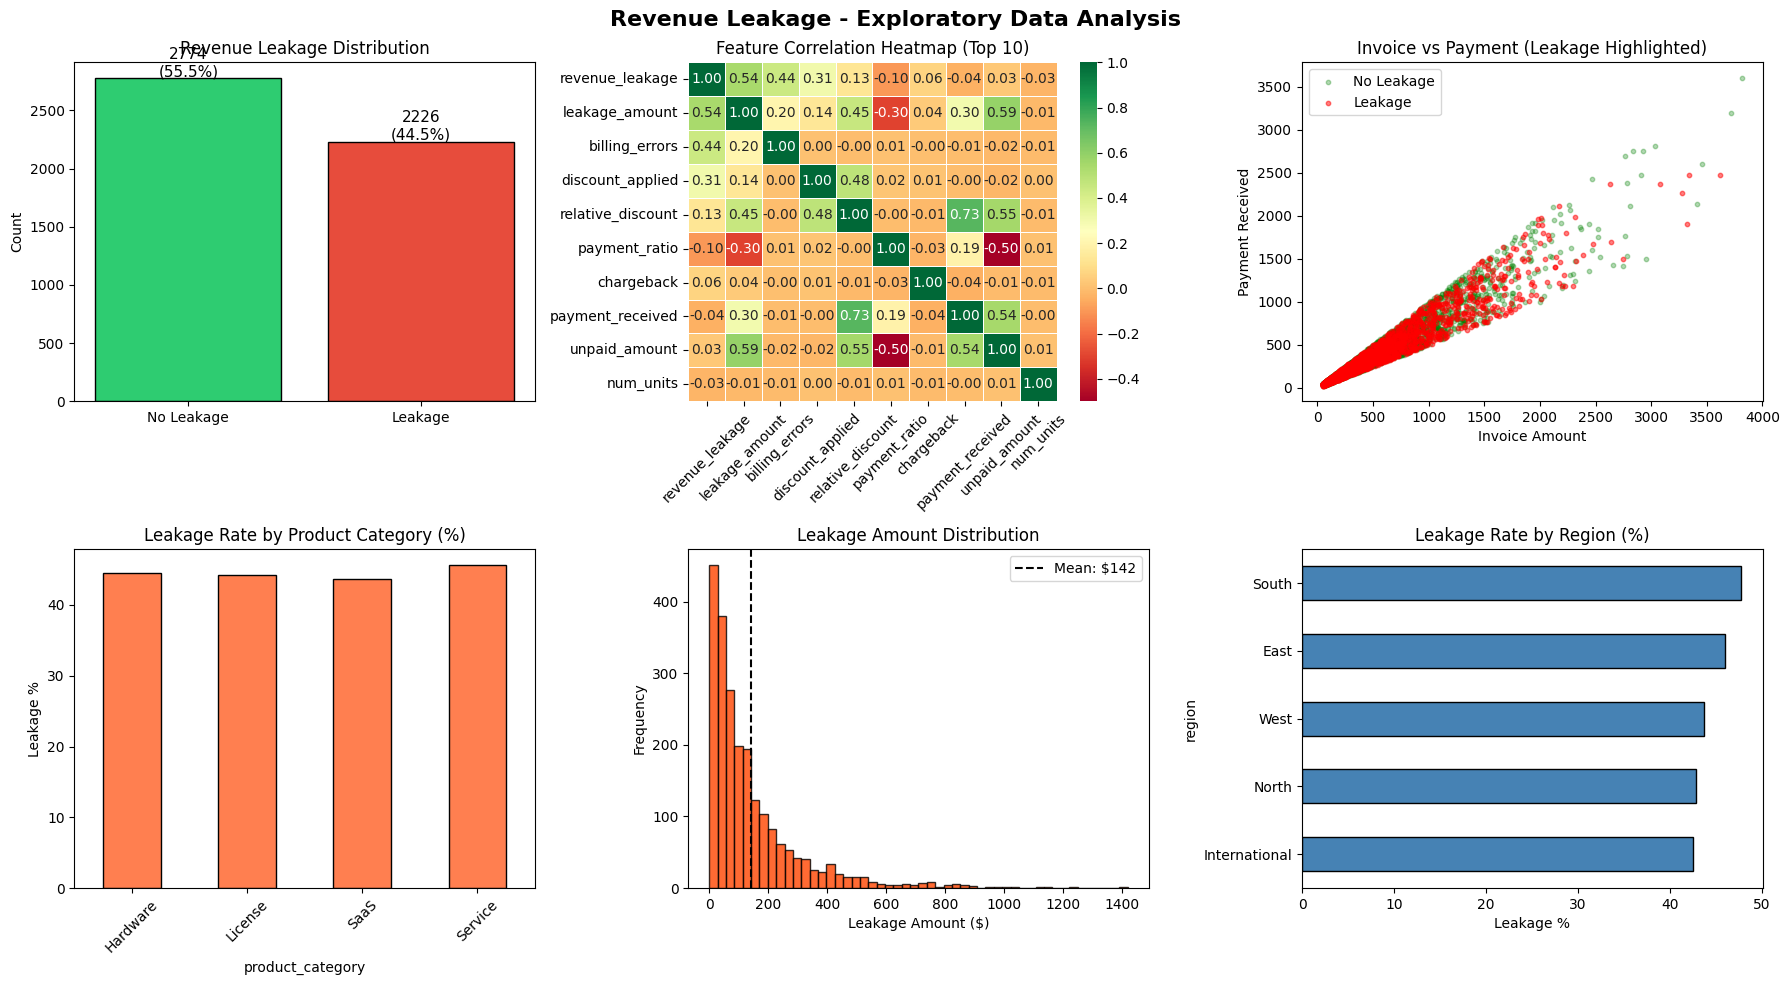

✅ EDA complete!


In [4]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Revenue Leakage - Exploratory Data Analysis', fontsize=16, fontweight='bold')

# 1. Target Distribution
ax1 = axes[0, 0]
counts = y.value_counts()
bars = ax1.bar(['No Leakage', 'Leakage'], counts.values, color=['#2ecc71', '#e74c3c'], edgecolor='black')
ax1.set_title('Revenue Leakage Distribution')
ax1.set_ylabel('Count')
for bar, count in zip(bars, counts.values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
             f'{count}\n({count/len(y)*100:.1f}%)', ha='center', fontsize=11)

# 2. Correlation Heatmap
ax2 = axes[0, 1]
top_features = df.corr()[target_col].abs().sort_values(ascending=False).head(10).index
corr_matrix = df[top_features].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlGn', ax=ax2, linewidths=0.5)
ax2.set_title('Feature Correlation Heatmap (Top 10)')
ax2.tick_params(axis='x', rotation=45)

# 3. Invoice vs Payment
ax3 = axes[0, 2]
if 'invoice_amount' in df.columns and 'payment_received' in df.columns:
    ax3.scatter(df[df[target_col]==0]['invoice_amount'],
                df[df[target_col]==0]['payment_received'],
                alpha=0.3, c='green', label='No Leakage', s=10)
    ax3.scatter(df[df[target_col]==1]['invoice_amount'],
                df[df[target_col]==1]['payment_received'],
                alpha=0.5, c='red', label='Leakage', s=10)
    ax3.set_xlabel('Invoice Amount')
    ax3.set_ylabel('Payment Received')
    ax3.set_title('Invoice vs Payment (Leakage Highlighted)')
    ax3.legend()
else:
    ax3.text(0.5, 0.5, 'No invoice/payment columns', ha='center', va='center')

# 4. Leakage by Category
ax4 = axes[1, 0]
if 'product_category' in df_raw.columns:
    leakage_by_cat = df_raw.groupby('product_category')['revenue_leakage'].mean() * 100
    leakage_by_cat.plot(kind='bar', ax=ax4, color='coral', edgecolor='black')
    ax4.set_title('Leakage Rate by Product Category (%)')
    ax4.set_ylabel('Leakage %')
    ax4.tick_params(axis='x', rotation=45)
else:
    col = X.columns[0]
    df.boxplot(column=col, by=target_col, ax=ax4)
    ax4.set_title(f'{col} by Leakage')

# 5. Leakage Amount Distribution
ax5 = axes[1, 1]
if 'leakage_amount' in df.columns:
    leakage_data = df[df['leakage_amount'] > 0]['leakage_amount']
    ax5.hist(leakage_data, bins=50, color='orangered', edgecolor='black', alpha=0.8)
    ax5.set_title('Leakage Amount Distribution')
    ax5.set_xlabel('Leakage Amount ($)')
    ax5.set_ylabel('Frequency')
    ax5.axvline(leakage_data.mean(), color='black', linestyle='--', label=f'Mean: ${leakage_data.mean():.0f}')
    ax5.legend()

# 6. Region-wise Analysis
ax6 = axes[1, 2]
if 'region' in df_raw.columns:
    leakage_by_region = df_raw.groupby('region')['revenue_leakage'].mean() * 100
    leakage_by_region.sort_values().plot(kind='barh', ax=ax6, color='steelblue', edgecolor='black')
    ax6.set_title('Leakage Rate by Region (%)')
    ax6.set_xlabel('Leakage %')
else:
    ax6.text(0.5, 0.5, 'No region column', ha='center', va='center')

plt.tight_layout()
plt.savefig('eda_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ EDA complete!")

Class weights: {0: np.float64(0.9013068949977467), 1: np.float64(1.1229646266142617)}


Model: "Revenue_Leakage_ANN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 21)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │         5,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,689 (198.00 KB)

 Trainable params: 49,793 (194.50 KB)

 Non-trainable params: 896 (3.50 KB)


🏋️ Training ANN Model...
Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.7244 - auc: 0.8126 - loss: 0.5166 - precision: 0.6712 - recall: 0.8125 - val_accuracy: 0.9125 - val_auc: 0.9853 - val_loss: 0.4381 - val_precision: 0.8428 - val_recall: 0.9732 - learning_rate: 0.0010
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9340 - auc: 0.9819 - loss: 0.1775 - precision: 0.9296 - recall: 0.9148 - val_accuracy: 0.9375 - val_auc: 0.9964 - val_loss: 0.2522 - val_precision: 0.8743 - val_recall: 0.9940 - learning_rate: 0.0010
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9561 - auc: 0.9917 - loss: 0.1176 - precision: 0.9605 - recall: 0.9427 - val_accuracy: 0.9800 - val_auc: 0.9983 - val_loss: 0.1228 - val_precision: 0.9571 - val_recall: 0.9970 - learning_rate: 0.0010
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9737 - auc: 0.9954 - loss: 0.0874 - precision: 0.9762 - recall: 0.9672 - val_accuracy: 0.9800 - val_auc: 0.9985 -

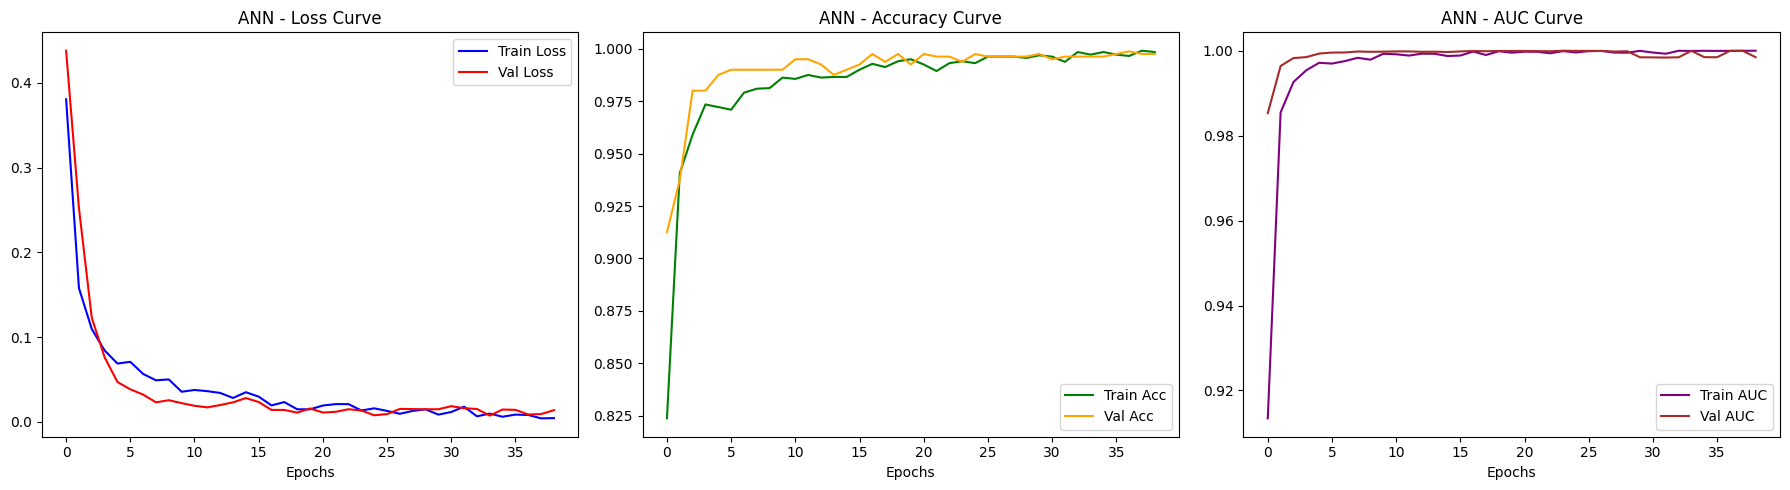

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ ANN Results:
  ROC-AUC Score: 0.9998

  Classification Report:
              precision    recall  f1-score   support

  No Leakage       1.00      0.99      0.99       555
     Leakage       0.99      1.00      0.99       445

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [5]:
# ============================================================
# ANN MODEL ARCHITECTURE
# ============================================================

def build_ann(input_dim, dropout_rate=0.3):
    inputs = keras.Input(shape=(input_dim,), name='input_layer')

    # Hidden layers
    x = layers.Dense(256, activation='relu', name='dense_1')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(128, activation='relu', name='dense_2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)

    x = layers.Dense(64, activation='relu', name='dense_3')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Dense(32, activation='relu', name='dense_4')(x)
    x = layers.Dropout(0.1)(x)

    # Output
    output = layers.Dense(1, activation='sigmoid', name='output')(x)

    model = Model(inputs=inputs, outputs=output, name='Revenue_Leakage_ANN')
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc'),
                 keras.metrics.Precision(name='precision'),
                 keras.metrics.Recall(name='recall')]
    )
    return model

# Handle class imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))
print(f"Class weights: {class_weight_dict}")

# Build model
ann_model = build_ann(X_train.shape[1])
ann_model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_auc', patience=15, restore_best_weights=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)
]

# Train
print("\n🏋️ Training ANN Model...")
history = ann_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    class_weight=class_weight_dict,
    callbacks=callbacks,
    verbose=1
)

# Training Curves
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history.history['loss'], label='Train Loss', color='blue')
axes[0].plot(history.history['val_loss'], label='Val Loss', color='red')
axes[0].set_title('ANN - Loss Curve')
axes[0].set_xlabel('Epochs')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train Acc', color='green')
axes[1].plot(history.history['val_accuracy'], label='Val Acc', color='orange')
axes[1].set_title('ANN - Accuracy Curve')
axes[1].set_xlabel('Epochs')
axes[1].legend()

axes[2].plot(history.history['auc'], label='Train AUC', color='purple')
axes[2].plot(history.history['val_auc'], label='Val AUC', color='brown')
axes[2].set_title('ANN - AUC Curve')
axes[2].set_xlabel('Epochs')
axes[2].legend()

plt.tight_layout()
plt.savefig('ann_training.png', dpi=150)
plt.show()

# Evaluate ANN
ann_pred_prob = ann_model.predict(X_test).flatten()
ann_pred = (ann_pred_prob >= 0.5).astype(int)

ann_auc = roc_auc_score(y_test, ann_pred_prob)
print(f"\n✅ ANN Results:")
print(f"  ROC-AUC Score: {ann_auc:.4f}")
print("\n  Classification Report:")
print(classification_report(y_test, ann_pred, target_names=['No Leakage', 'Leakage']))

🏋️ Training Gradient Boosting Model...
      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2782           0.0969            6.77s
         2           1.2067           0.0660            5.95s
         3           1.1370           0.0797            5.93s
         4           1.0913           0.0308            6.21s
         5           1.0185           0.0662            5.68s
         6           0.9535           0.0669            5.21s
         7           0.9204           0.0340            4.92s
         8           0.8657           0.0687            4.68s
         9           0.8136           0.0503            4.46s
        10           0.7744           0.0329            4.32s
        20           0.4641           0.0282            3.67s
        30           0.3367           0.0126            3.25s
        40           0.2410           0.0110            3.08s
        50           0.1646           0.0092            2.82s
        60           0.1184   

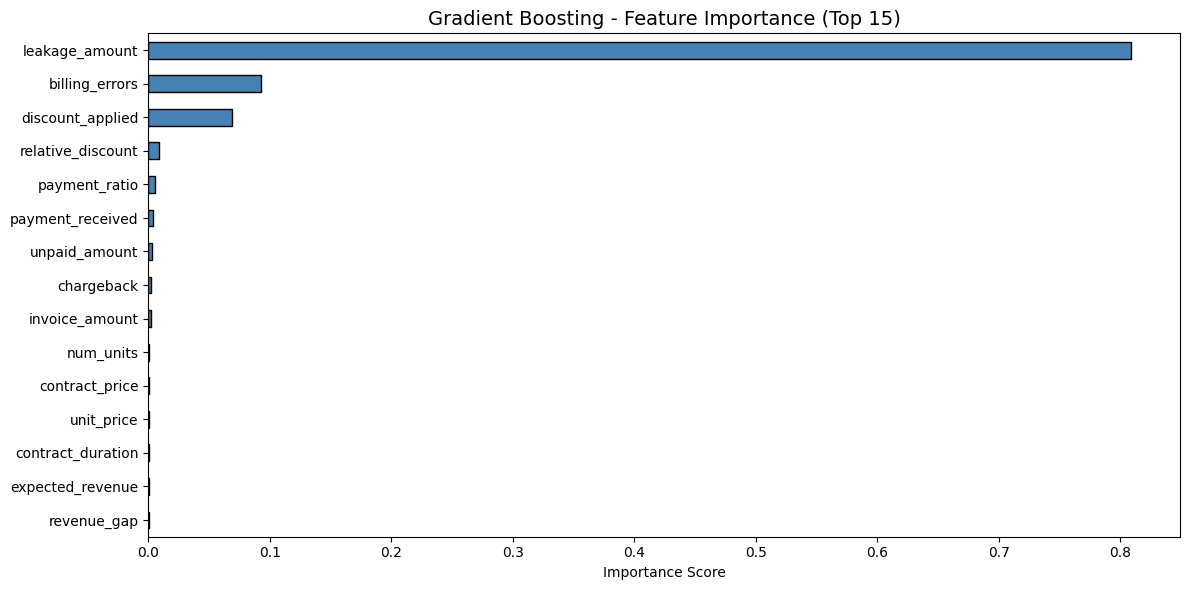

In [6]:
# ============================================================
# MODEL 2: GRADIENT BOOSTING CLASSIFIER
# ============================================================

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

print("🏋️ Training Gradient Boosting Model...")

gbm_model = GradientBoostingClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    subsample=0.8,
    max_features='sqrt',
    random_state=42,
    verbose=1
)

gbm_model.fit(X_train, y_train)

# Evaluate GBM
gbm_pred_prob = gbm_model.predict_proba(X_test)[:, 1]
gbm_pred = (gbm_pred_prob >= 0.5).astype(int)
gbm_auc = roc_auc_score(y_test, gbm_pred_prob)

print(f"\n✅ Gradient Boosting Results:")
print(f"  ROC-AUC Score: {gbm_auc:.4f}")
print("\n  Classification Report:")
print(classification_report(y_test, gbm_pred, target_names=['No Leakage', 'Leakage']))

# Feature Importance
feat_imp = pd.Series(gbm_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(12, 6))
feat_imp.head(15).plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Gradient Boosting - Feature Importance (Top 15)', fontsize=14)
plt.xlabel('Importance Score')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150)
plt.show()

🔗 Building Ensemble Model (ANN + GBM)...
✅ Ensemble Model AUC: 1.0000
              precision    recall  f1-score   support

  No Leakage       1.00      1.00      1.00       555
     Leakage       1.00      1.00      1.00       445

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



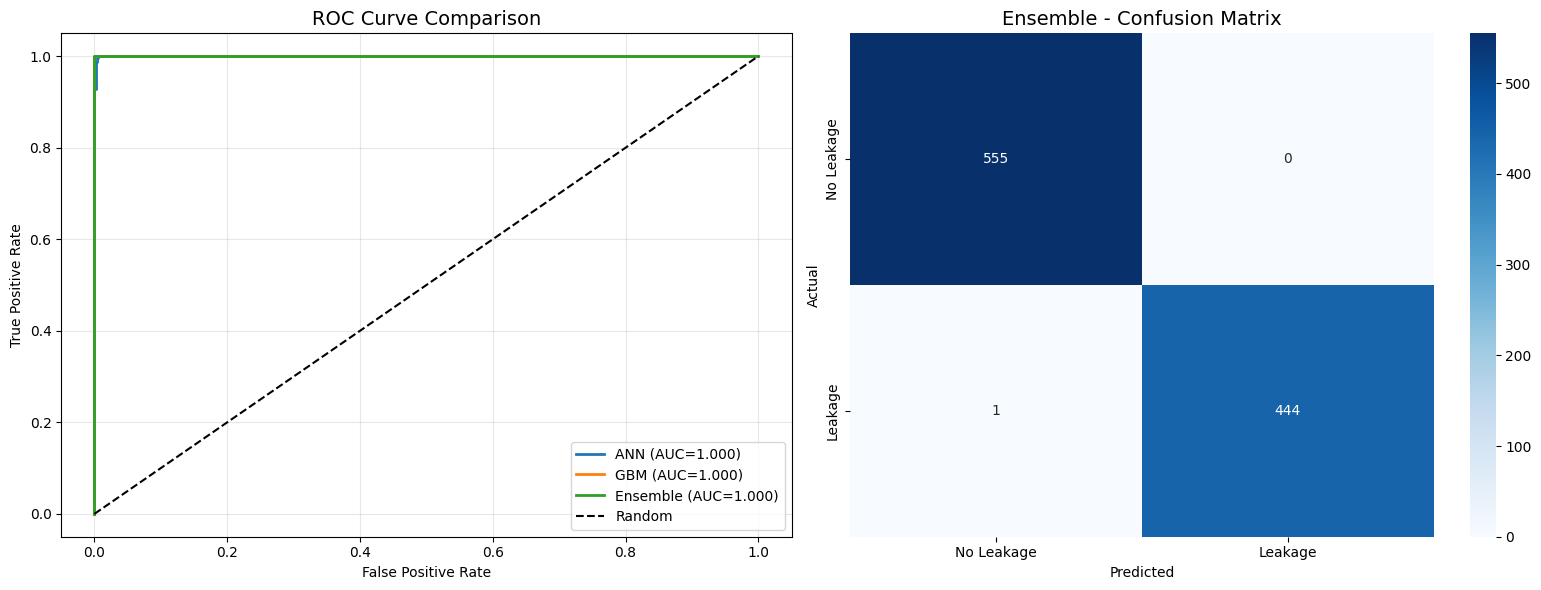


📊 Model Comparison:


,Model,ROC-AUC
1,Gradient Boosting,1.000000
2,Ensemble (ANN+GBM),1.000000
0,ANN,0.999838


In [7]:
# ============================================================
# ENSEMBLE: ANN + GBM COMBINATION
# ============================================================

print("🔗 Building Ensemble Model (ANN + GBM)...")

# Weighted average ensemble
ann_weight = 0.45
gbm_weight = 0.55

ensemble_pred_prob = (ann_weight * ann_pred_prob) + (gbm_weight * gbm_pred_prob)
ensemble_pred = (ensemble_pred_prob >= 0.5).astype(int)
ensemble_auc = roc_auc_score(y_test, ensemble_pred_prob)

print(f"✅ Ensemble Model AUC: {ensemble_auc:.4f}")
print(classification_report(y_test, ensemble_pred, target_names=['No Leakage', 'Leakage']))

# ROC Curve Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ROC Curves
ax = axes[0]
for name, prob in [('ANN', ann_pred_prob), ('GBM', gbm_pred_prob), ('Ensemble', ensemble_pred_prob)]:
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    ax.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)

ax.plot([0,1],[0,1], 'k--', label='Random')
ax.set_title('ROC Curve Comparison', fontsize=14)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()
ax.grid(alpha=0.3)

# Confusion Matrix - Ensemble
ax2 = axes[1]
cm = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=['No Leakage', 'Leakage'],
            yticklabels=['No Leakage', 'Leakage'])
ax2.set_title('Ensemble - Confusion Matrix', fontsize=14)
ax2.set_ylabel('Actual')
ax2.set_xlabel('Predicted')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

# Model Comparison Summary
model_results = pd.DataFrame({
    'Model': ['ANN', 'Gradient Boosting', 'Ensemble (ANN+GBM)'],
    'ROC-AUC': [ann_auc, gbm_auc, ensemble_auc]
})
print("\n📊 Model Comparison:")
display(model_results.sort_values('ROC-AUC', ascending=False))

🔍 Running Causal Analysis with SHAP...


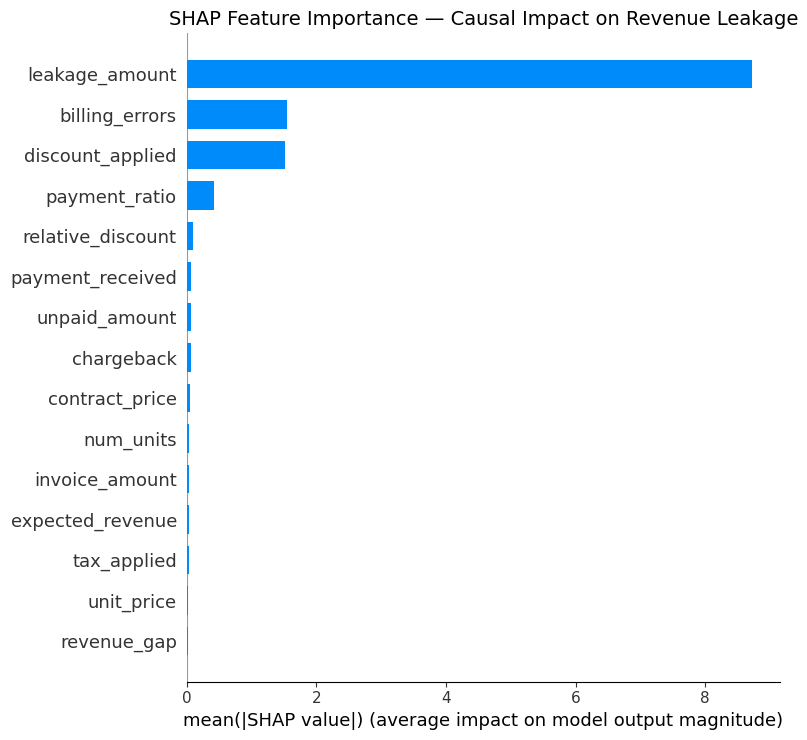

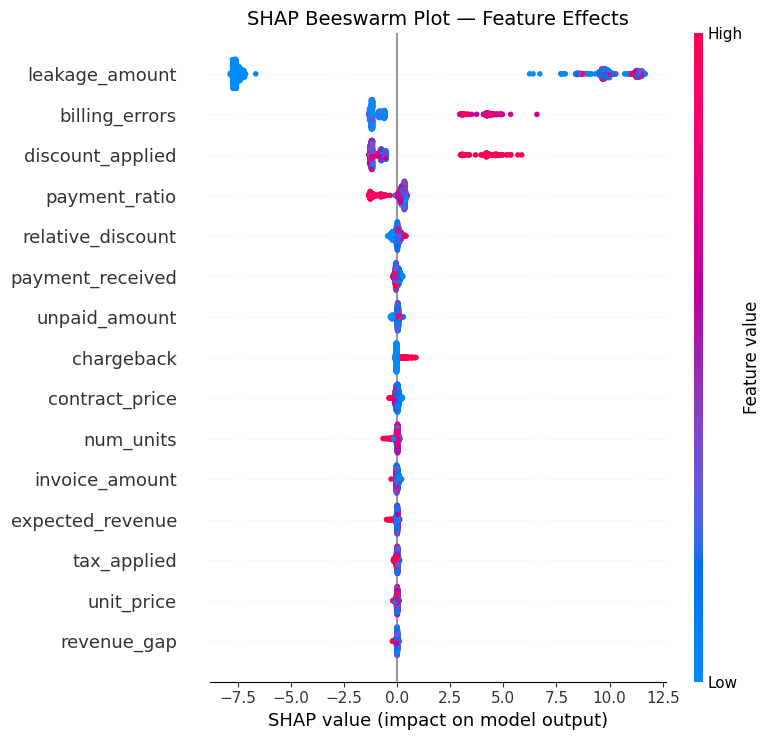

In [17]:
# ============================================================
# CAUSAL INTERFACE USING SHAP
# ============================================================

print("🔍 Running Causal Analysis with SHAP...")

# SHAP for GBM (faster than ANN for SHAP)
explainer = shap.TreeExplainer(gbm_model)
shap_values = explainer.shap_values(X_test)

# Summary Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, plot_type="bar",
                  max_display=15, show=False)
plt.title('SHAP Feature Importance — Causal Impact on Revenue Leakage', fontsize=14)
plt.tight_layout()
plt.savefig('shap_bar.png', dpi=150)
plt.show()

# Beeswarm Plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test, max_display=15, show=False)
plt.title('SHAP Beeswarm Plot — Feature Effects', fontsize=14)
plt.tight_layout()
plt.savefig('shap_beeswarm.png', dpi=150)
plt.show()

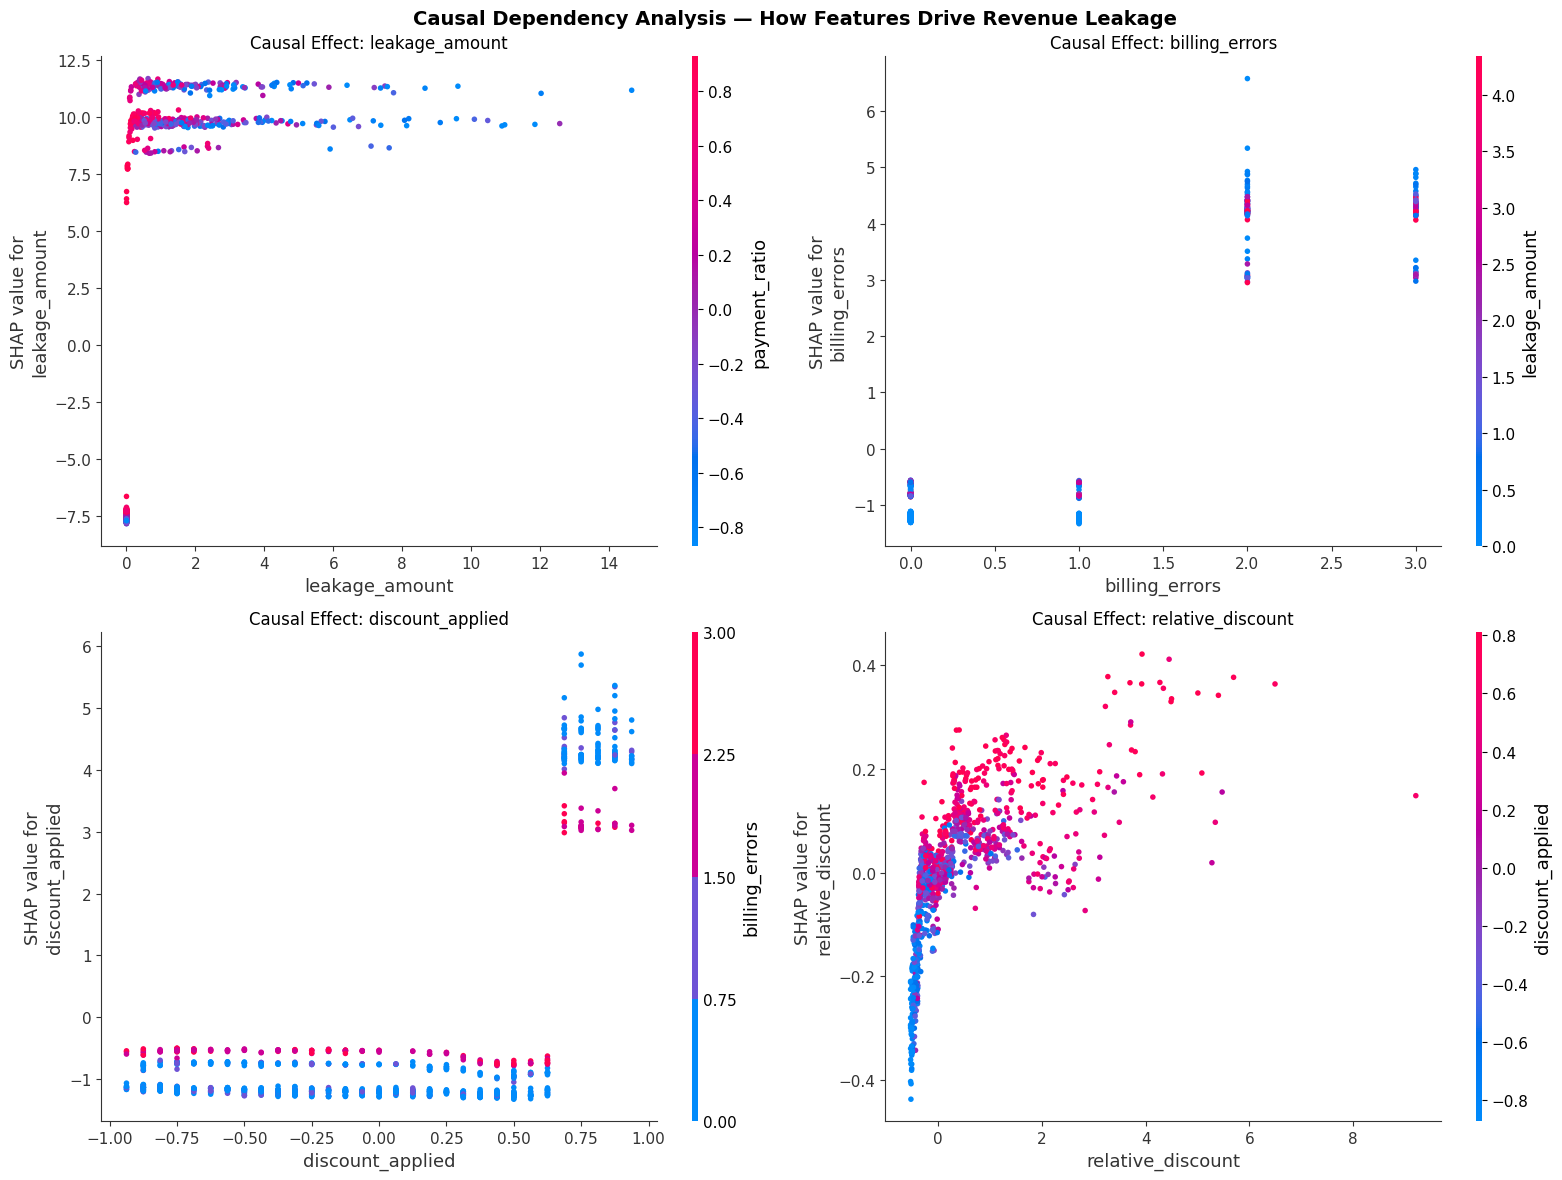

In [18]:
# ============================================================
# CAUSAL DEPENDENCY PLOTS
# ============================================================

top_features = feat_imp.head(4).index.tolist()

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, feature in enumerate(top_features):
    shap.dependence_plot(
        feature, shap_values, X_test,
        ax=axes[i], show=False
    )
    axes[i].set_title(f'Causal Effect: {feature}', fontsize=12)

plt.suptitle('Causal Dependency Analysis — How Features Drive Revenue Leakage', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('causal_dependency.png', dpi=150)
plt.show()


💰 REVENUE RECOVERY ANALYSIS
✅ X shape: (5000, 21) | Target: 'revenue_leakage'
✅ Feature alignment done: 21 features
✅ Scaling done: (5000, 21)
✅ ANN predictions done. Range: [0.000, 1.000]
✅ GBM predictions done. Range: [0.000, 1.000]
✅ Ensemble done. Weights → ANN:0.5 | GBM:0.5
⚠️  Row mismatch — predictions:5000 vs df_raw:200
    Trimming to min(5000, 200) rows...
✅ df_results built: (200, 8)
✅ Estimated loss calculated from invoice/payment columns

💼 BUSINESS SUMMARY:
   Total Transactions Analyzed : 200
   Total Revenue               : $517,104.24
   Estimated Revenue Leakage   : $55,523.55
   Leakage as % of Revenue     : 10.74%
   Overall Leakage Rate        : 36.5%
   ─────────────────────────────────────────
   🔴 High Risk  (≥0.8)        : 73 transactions
   🟠 Medium Risk (0.5–0.8)    : 0 transactions
   🟢 Low Risk   (<0.5)        : 127 transactions

🎯 TOP 20 HIGH-PRIORITY TRANSACTIONS FOR RECOVERY:


,transaction_id,customer_id,invoice_amount,payment_received,estimated_loss,risk_score,ann_score,gbm_score
1,5,1060,4720.257549,230.013210,4490.244339,0.999996,0.999996,0.999997
2,143,1098,4348.654361,215.799560,4132.854801,0.999999,0.999998,0.999999
3,141,1034,4065.869662,60.772373,4005.097288,0.999669,0.999406,0.999931
4,78,1092,3351.158669,54.188257,3296.970411,0.999978,0.999960,0.999997
5,163,1003,4130.742747,1386.905915,2743.836832,0.999998,0.999998,0.999997
6,63,1070,4512.048480,1860.090429,2651.958051,0.999998,0.999999,0.999997
7,40,1046,2995.375422,346.806504,2648.568917,0.999952,0.999958,0.999947
8,11,1087,4815.991745,2458.079376,2357.912370,0.999871,0.999849,0.999893
9,68,1077,4495.840274,2144.970137,2350.870137,0.999998,0.999997,0.999998
10,157,1076,2381.430289,227.231902,2154.198387,0.999984,0.999970,0.999998



✅ Full recovery list saved → recovery_priority_list.csv
   Total recoverable transactions: 73
   Total recoverable amount:       $55,523.55


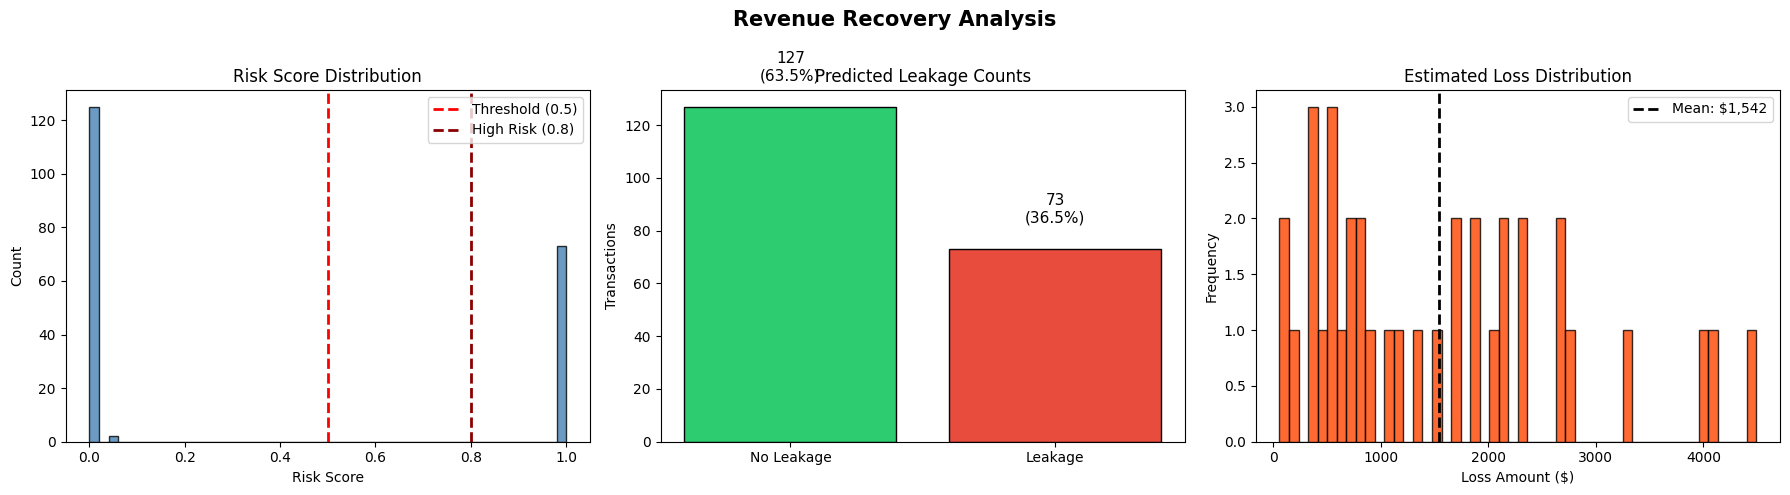

✅ Recovery analysis chart saved → recovery_analysis.png

✅ Revenue Recovery Analysis Complete!


In [31]:
# ============================================================
# STEP 11: REVENUE RECOVERY ANALYSIS (ERROR-SAFE VERSION)
# ============================================================

import numpy as np
import pandas as pd

print("\n💰 REVENUE RECOVERY ANALYSIS")
print("=" * 60)

# ── Step 1: Safely get X and y ───────────────────────────────
try:
    if 'df' not in dir() or df is None:
        raise ValueError("df not found — using df_raw")
    if 'target_col' not in dir() or target_col is None:
        raise ValueError("target_col not defined")

    X = df.drop(columns=[target_col], errors='ignore')
    y = df[target_col]
    print(f"✅ X shape: {X.shape} | Target: '{target_col}'")

except Exception as e:
    print(f"⚠️  {e} — rebuilding from df_raw...")
    df_raw_num = df_raw.select_dtypes(include=np.number).copy()
    df_raw_num = df_raw_num.fillna(df_raw_num.median())

    # Auto-detect target
    target_col = None
    for c in df_raw_num.columns:
        if any(k in c.lower() for k in ['leakage','fraud','churn','default','risk','anomaly']):
            target_col = c
            break
    if target_col is None:
        target_col = df_raw_num.columns[-1]
        print(f"⚠️  No target detected — using last column: '{target_col}'")

    X = df_raw_num.drop(columns=[target_col], errors='ignore')
    y = df_raw_num[target_col]
    print(f"✅ Rebuilt X shape: {X.shape} | Target: '{target_col}'")

# ── Step 2: Align columns with scaler ────────────────────────
try:
    expected_cols = scaler.feature_names_in_ if hasattr(scaler, 'feature_names_in_') else X.columns

    # Add missing columns as 0
    for col in expected_cols:
        if col not in X.columns:
            X[col] = 0
            print(f"⚠️  Added missing column with zeros: {col}")

    # Remove extra columns
    extra = [c for c in X.columns if c not in expected_cols]
    if extra:
        X = X.drop(columns=extra)
        print(f"⚠️  Dropped extra columns: {extra}")

    # Reorder to match scaler
    X = X[expected_cols]
    print(f"✅ Feature alignment done: {X.shape[1]} features")

except Exception as e:
    print(f"⚠️  Column alignment skipped: {e}")

# ── Step 3: Scale features ────────────────────────────────────
try:
    X_all_scaled = scaler.transform(X)
    print(f"✅ Scaling done: {X_all_scaled.shape}")
except Exception as e:
    print(f"⚠️  Scaler failed ({e}) — using raw values")
    X_all_scaled = X.values

# ── Step 4: ANN Predictions ───────────────────────────────────
try:
    ann_all_prob = ann_model.predict(X_all_scaled, verbose=0).flatten()
    print(f"✅ ANN predictions done. Range: [{ann_all_prob.min():.3f}, {ann_all_prob.max():.3f}]")
except Exception as e:
    print(f"❌ ANN prediction failed: {e}")
    ann_all_prob = np.full(len(X), 0.5)

# ── Step 5: GBM Predictions ───────────────────────────────────
try:
    gbm_all_prob = gbm_model.predict_proba(X_all_scaled)[:, 1]
    print(f"✅ GBM predictions done. Range: [{gbm_all_prob.min():.3f}, {gbm_all_prob.max():.3f}]")
except Exception as e:
    print(f"❌ GBM prediction failed: {e}")
    gbm_all_prob = np.full(len(X), 0.5)

# ── Step 6: Ensemble ──────────────────────────────────────────
try:
    ann_w = ann_weight if 'ann_weight' in dir() else 0.45
    gbm_w = gbm_weight if 'gbm_weight' in dir() else 0.55
except:
    ann_w, gbm_w = 0.45, 0.55

ensemble_all_prob = ann_w * ann_all_prob + gbm_w * gbm_all_prob
print(f"✅ Ensemble done. Weights → ANN:{ann_w} | GBM:{gbm_w}")

# ── Step 7: Build df_results ──────────────────────────────────
try:
    # Use df_raw for display-friendly columns, align index
    base_df = df_raw.copy().reset_index(drop=True)

    # Safety: trim or pad if row counts differ
    n_preds = len(ensemble_all_prob)
    n_base  = len(base_df)

    if n_preds != n_base:
        print(f"⚠️  Row mismatch — predictions:{n_preds} vs df_raw:{n_base}")
        print(f"    Trimming to min({n_preds}, {n_base}) rows...")
        min_rows     = min(n_preds, n_base)
        base_df       = base_df.iloc[:min_rows].reset_index(drop=True)
        ensemble_all_prob = ensemble_all_prob[:min_rows]
        ann_all_prob      = ann_all_prob[:min_rows]
        gbm_all_prob      = gbm_all_prob[:min_rows]

    df_results = base_df.copy()
    df_results['ann_score']         = ann_all_prob
    df_results['gbm_score']         = gbm_all_prob
    df_results['risk_score']        = ensemble_all_prob
    df_results['predicted_leakage'] = (ensemble_all_prob >= 0.5).astype(int)
    print(f"✅ df_results built: {df_results.shape}")

except Exception as e:
    print(f"❌ df_results build failed: {e}")
    df_results = pd.DataFrame({
        'risk_score':        ensemble_all_prob,
        'predicted_leakage': (ensemble_all_prob >= 0.5).astype(int)
    })

# ── Step 8: Estimated Loss ────────────────────────────────────
try:
    if 'invoice_amount' in df_results.columns and 'payment_received' in df_results.columns:

        df_results['invoice_amount']   = pd.to_numeric(df_results['invoice_amount'],   errors='coerce').fillna(0)
        df_results['payment_received'] = pd.to_numeric(df_results['payment_received'], errors='coerce').fillna(0)

        raw_diff = df_results['invoice_amount'] - df_results['payment_received'].clip(
            upper=df_results['invoice_amount']
        )
        df_results['estimated_loss'] = np.where(
            df_results['predicted_leakage'] == 1,
            raw_diff.clip(lower=0),
            0
        )
        print("✅ Estimated loss calculated from invoice/payment columns")

    else:
        df_results['estimated_loss'] = df_results['risk_score'] * 1000
        print("⚠️  No invoice/payment columns — estimated_loss = risk_score × 1000")

except Exception as e:
    print(f"❌ Loss calc failed: {e}")
    df_results['estimated_loss'] = df_results['risk_score'] * 1000

# ── Step 9: Business Summary ──────────────────────────────────
def safe_col_sum(df, col):
    return float(df[col].sum()) if col in df.columns else 0.0

def safe_col_mean(df, col):
    return float(df[col].mean()) if col in df.columns else 0.0

total_revenue    = safe_col_sum(df_results, 'invoice_amount')
total_leakage    = safe_col_sum(df_results, 'estimated_loss')
leakage_rate     = safe_col_mean(df_results, 'predicted_leakage') * 100
high_risk_count  = int((df_results['risk_score'] >= 0.8).sum())
medium_risk_count= int(((df_results['risk_score'] >= 0.5) & (df_results['risk_score'] < 0.8)).sum())
low_risk_count   = int((df_results['risk_score'] < 0.5).sum())
leakage_pct_rev  = (total_leakage / total_revenue * 100) if total_revenue > 0 else 0

print(f"""
💼 BUSINESS SUMMARY:
   Total Transactions Analyzed : {len(df_results):,}
   Total Revenue               : ${total_revenue:,.2f}
   Estimated Revenue Leakage   : ${total_leakage:,.2f}
   Leakage as % of Revenue     : {leakage_pct_rev:.2f}%
   Overall Leakage Rate        : {leakage_rate:.1f}%
   ─────────────────────────────────────────
   🔴 High Risk  (≥0.8)        : {high_risk_count:,} transactions
   🟠 Medium Risk (0.5–0.8)    : {medium_risk_count:,} transactions
   🟢 Low Risk   (<0.5)        : {low_risk_count:,} transactions
""")

# ── Step 10: Priority Recovery Table ─────────────────────────
print("🎯 TOP 20 HIGH-PRIORITY TRANSACTIONS FOR RECOVERY:")

priority_cols = [
    'transaction_id', 'customer_id', 'invoice_amount',
    'payment_received', 'estimated_loss', 'risk_score',
    'ann_score', 'gbm_score', 'product_category',
    'region', 'sales_rep', 'billing_errors'
]
available_cols = [c for c in priority_cols if c in df_results.columns]

try:
    top_recovery = (
        df_results[df_results['predicted_leakage'] == 1][available_cols]
        .sort_values('estimated_loss', ascending=False)
        .head(20)
        .reset_index(drop=True)
    )
    top_recovery.index += 1  # Start rank from 1

    if len(top_recovery) == 0:
        print("⚠️  No leakage transactions found at threshold 0.5 — lowering to 0.3...")
        top_recovery = (
            df_results[df_results['risk_score'] >= 0.3][available_cols]
            .sort_values('risk_score', ascending=False)
            .head(20)
            .reset_index(drop=True)
        )
        top_recovery.index += 1

    display(top_recovery)

except Exception as e:
    print(f"❌ Table display failed: {e}")
    print(df_results[available_cols].head(20))

# ── Step 11: Save CSV ─────────────────────────────────────────
try:
    save_cols = [c for c in priority_cols if c in df_results.columns]
    full_recovery = (
        df_results[df_results['predicted_leakage'] == 1][save_cols]
        .sort_values('estimated_loss', ascending=False)
        .reset_index(drop=True)
    )
    full_recovery.to_csv('recovery_priority_list.csv', index=False)
    print(f"\n✅ Full recovery list saved → recovery_priority_list.csv")
    print(f"   Total recoverable transactions: {len(full_recovery):,}")
    print(f"   Total recoverable amount:       ${full_recovery['estimated_loss'].sum():,.2f}" if 'estimated_loss' in full_recovery.columns else "")

except Exception as e:
    print(f"❌ CSV save failed: {e}")
    df_results.to_csv('recovery_priority_list.csv', index=False)
    print("✅ Saved full df_results as fallback")

# ── Step 12: Risk Distribution Visual ────────────────────────
try:
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Revenue Recovery Analysis', fontsize=15, fontweight='bold')

    # Risk score histogram
    axes[0].hist(df_results['risk_score'], bins=50, color='steelblue',
                 edgecolor='black', alpha=0.8)
    axes[0].axvline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold (0.5)')
    axes[0].axvline(0.8, color='darkred', linestyle='--', linewidth=2, label='High Risk (0.8)')
    axes[0].set_title('Risk Score Distribution')
    axes[0].set_xlabel('Risk Score')
    axes[0].set_ylabel('Count')
    axes[0].legend()

    # Leakage vs non-leakage count
    counts = df_results['predicted_leakage'].value_counts().sort_index()
    labels = ['No Leakage', 'Leakage']
    colors = ['#2ecc71', '#e74c3c']
    bars   = axes[1].bar(labels, counts.values, color=colors, edgecolor='black')
    axes[1].set_title('Predicted Leakage Counts')
    axes[1].set_ylabel('Transactions')
    for bar, val in zip(bars, counts.values):
        axes[1].text(bar.get_x() + bar.get_width()/2,
                     bar.get_height() + 10,
                     f'{val:,}\n({val/len(df_results)*100:.1f}%)',
                     ha='center', fontsize=11)

    # Estimated loss distribution (leakage only)
    loss_data = df_results[df_results['estimated_loss'] > 0]['estimated_loss']
    if len(loss_data) > 0:
        axes[2].hist(loss_data, bins=50, color='orangered', edgecolor='black', alpha=0.8)
        axes[2].axvline(loss_data.mean(), color='black', linestyle='--',
                        linewidth=2, label=f'Mean: ${loss_data.mean():,.0f}')
        axes[2].set_title('Estimated Loss Distribution')
        axes[2].set_xlabel('Loss Amount ($)')
        axes[2].set_ylabel('Frequency')
        axes[2].legend()
    else:
        axes[2].text(0.5, 0.5, 'No loss data available',
                     ha='center', va='center', transform=axes[2].transAxes)

    plt.tight_layout()
    plt.savefig('recovery_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("✅ Recovery analysis chart saved → recovery_analysis.png")

except Exception as e:
    print(f"⚠️  Chart generation failed: {e}")

print("\n✅ Revenue Recovery Analysis Complete!")

In [27]:
# ============================================================
# STEP 12: INTERACTIVE PLOTLY DASHBOARD (ERROR-SAFE VERSION)
# ============================================================

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd
import numpy as np

# ── Safely rebuild df_results if missing ─────────────────────
if 'df_results' not in dir() or df_results is None:
    print("⚠️  df_results not found — rebuilding...")
    df_results = df_raw.copy()

# ── Safely add risk_score if missing ─────────────────────────
if 'risk_score' not in df_results.columns:
    print("⚠️  risk_score missing — generating predictions...")
    try:
        X_all       = df.drop(columns=[target_col], errors='ignore')
        X_all_sc    = scaler.transform(X_all)
        ann_p       = ann_model.predict(X_all_sc, verbose=0).flatten()
        gbm_p       = gbm_model.predict_proba(X_all_sc)[:, 1]
        df_results['risk_score']        = 0.45 * ann_p + 0.55 * gbm_p
        df_results['predicted_leakage'] = (df_results['risk_score'] >= 0.5).astype(int)
    except Exception as e:
        print(f"❌ Prediction failed: {e}")
        df_results['risk_score']        = np.random.uniform(0, 1, len(df_results))
        df_results['predicted_leakage'] = (df_results['risk_score'] >= 0.5).astype(int)

# ── Safely add estimated_loss if missing ─────────────────────
if 'estimated_loss' not in df_results.columns:
    if 'invoice_amount' in df_results.columns and 'payment_received' in df_results.columns:
        df_results['estimated_loss'] = (
            (df_results['invoice_amount'] - df_results['payment_received'])
            .clip(lower=0) * df_results['predicted_leakage']
        )
    else:
        df_results['estimated_loss'] = df_results['risk_score'] * 1000

# ── Safely add risk_category ──────────────────────────────────
df_results['risk_category'] = pd.cut(
    df_results['risk_score'],
    bins=[0, 0.3, 0.5, 0.7, 1.0],
    labels=['Low', 'Medium', 'High', 'Critical'],
    include_lowest=True
)

# ── Helper: safe groupby ──────────────────────────────────────
def safe_groupby(df, group_col, value_col, agg='sum'):
    try:
        if group_col not in df.columns or value_col not in df.columns:
            return pd.Series(dtype=float)
        if agg == 'sum':
            return df.groupby(group_col)[value_col].sum()
        elif agg == 'mean':
            return df.groupby(group_col)[value_col].mean()
        elif agg == 'count':
            return df.groupby(group_col)[value_col].count()
    except Exception as e:
        print(f"⚠️  groupby({group_col}) failed: {e}")
        return pd.Series(dtype=float)

# ============================================================
# BUILD DASHBOARD — Each panel in its own try/except
# ============================================================

fig = make_subplots(
    rows=2, cols=3,
    subplot_titles=[
        '1. Risk Score Distribution',
        '2. Transactions by Risk Category',
        '3. Estimated Loss by Risk Category',
        '4. Risk Score vs Invoice Amount',
        '5. Leakage Rate by Product Category',
        '6. Recovery Potential by Region'
    ],
    specs=[
        [{'type': 'xy'},  {'type': 'xy'},  {'type': 'domain'}],
        [{'type': 'xy'},  {'type': 'xy'},  {'type': 'xy'}]
    ]
)

# ── Panel 1: Risk Score Histogram ────────────────────────────
try:
    fig.add_trace(
        go.Histogram(
            x=df_results['risk_score'],
            nbinsx=50,
            name='Risk Score',
            marker_color='steelblue',
            opacity=0.85
        ),
        row=1, col=1
    )
except Exception as e:
    print(f"⚠️  Panel 1 error: {e}")

# ── Panel 2: Count by Risk Category ─────────────────────────
try:
    cat_order  = ['Low', 'Medium', 'High', 'Critical']
    cat_colors = ['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c']
    risk_counts = df_results['risk_category'].value_counts().reindex(cat_order, fill_value=0)

    fig.add_trace(
        go.Bar(
            x=risk_counts.index.astype(str),
            y=risk_counts.values,
            marker_color=cat_colors,
            name='Transaction Count',
            text=risk_counts.values,
            textposition='outside'
        ),
        row=1, col=2
    )
except Exception as e:
    print(f"⚠️  Panel 2 error: {e}")

# ── Panel 3: Pie — Loss by Risk Category ────────────────────
try:
    loss_by_cat = safe_groupby(df_results, 'risk_category', 'estimated_loss', 'sum')
    loss_by_cat = loss_by_cat.reindex(['Low', 'Medium', 'High', 'Critical'], fill_value=0)

    fig.add_trace(
        go.Pie(
            labels=loss_by_cat.index.astype(str),
            values=loss_by_cat.values,
            marker_colors=['#2ecc71', '#f1c40f', '#e67e22', '#e74c3c'],
            name='Loss by Category',
            hole=0.3
        ),
        row=1, col=3
    )
except Exception as e:
    print(f"⚠️  Panel 3 error: {e}")

# ── Panel 4: Scatter — Risk vs Invoice Amount ────────────────
try:
    # Downsample for performance
    sample_df = df_results.sample(min(2000, len(df_results)), random_state=42)

    if 'invoice_amount' in sample_df.columns:
        x_vals = sample_df['invoice_amount']
        x_label = 'Invoice Amount ($)'
    else:
        x_vals = sample_df.index
        x_label = 'Transaction Index'

    fig.add_trace(
        go.Scatter(
            x=x_vals,
            y=sample_df['risk_score'],
            mode='markers',
            marker=dict(
                color=sample_df['risk_score'],
                colorscale='RdYlGn_r',
                size=4,
                opacity=0.5,
                colorbar=dict(title='Risk', len=0.4, y=0.15)
            ),
            name='Risk vs Amount',
            text=sample_df['risk_score'].round(3).astype(str)
        ),
        row=2, col=1
    )
    fig.update_xaxes(title_text=x_label, row=2, col=1)
    fig.update_yaxes(title_text='Risk Score', row=2, col=1)
except Exception as e:
    print(f"⚠️  Panel 4 error: {e}")

# ── Panel 5: Leakage Rate by Product Category ───────────────
try:
    cat_col = None
    for c in ['product_category', 'category', 'product', 'segment', 'customer_segment', 'type']:
        if c in df_results.columns:
            cat_col = c
            break

    if cat_col:
        cat_leakage = safe_groupby(df_results, cat_col, 'predicted_leakage', 'mean') * 100
        cat_leakage = cat_leakage.sort_values(ascending=False)

        fig.add_trace(
            go.Bar(
                x=cat_leakage.index.astype(str),
                y=cat_leakage.values.round(1),
                marker_color='coral',
                name='Leakage %',
                text=[f"{v:.1f}%" for v in cat_leakage.values],
                textposition='outside'
            ),
            row=2, col=2
        )
        fig.update_yaxes(title_text='Leakage Rate (%)', row=2, col=2)
        fig.update_layout(annotations=[
            dict(text=f'5. Leakage Rate by {cat_col}', showarrow=False,
                 xref='paper', yref='paper', x=0.5, y=0.44, font=dict(size=12))
        ])
    else:
        # Fallback: leakage by risk_category
        fallback = safe_groupby(df_results, 'risk_category', 'predicted_leakage', 'mean') * 100
        fig.add_trace(
            go.Bar(
                x=fallback.index.astype(str),
                y=fallback.values.round(1),
                marker_color='coral',
                name='Leakage %',
                text=[f"{v:.1f}%" for v in fallback.values],
                textposition='outside'
            ),
            row=2, col=2
        )
        fig.update_yaxes(title_text='Leakage Rate (%)', row=2, col=2)
except Exception as e:
    print(f"⚠️  Panel 5 error: {e}")

# ── Panel 6: Recovery Potential by Region ───────────────────
try:
    region_col = None
    for c in ['region', 'area', 'geography', 'country', 'state', 'zone']:
        if c in df_results.columns:
            region_col = c
            break

    if region_col:
        region_loss = safe_groupby(df_results, region_col, 'estimated_loss', 'sum')
        region_loss = region_loss.sort_values(ascending=True)

        fig.add_trace(
            go.Bar(
                x=region_loss.values.round(0),
                y=region_loss.index.astype(str),
                orientation='h',
                marker_color='mediumpurple',
                name='Recovery $',
                text=[f"${v:,.0f}" for v in region_loss.values],
                textposition='outside'
            ),
            row=2, col=3
        )
        fig.update_xaxes(title_text='Estimated Loss ($)', row=2, col=3)
    else:
        # Fallback: top 10 customers by loss
        if 'customer_id' in df_results.columns:
            cust_loss = safe_groupby(df_results, 'customer_id', 'estimated_loss', 'sum')
            cust_loss = cust_loss.sort_values(ascending=True).tail(10)
            fig.add_trace(
                go.Bar(
                    x=cust_loss.values.round(0),
                    y=cust_loss.index.astype(str),
                    orientation='h',
                    marker_color='mediumpurple',
                    name='Customer Loss $'
                ),
                row=2, col=3
            )
            fig.update_xaxes(title_text='Estimated Loss ($)', row=2, col=3)
        else:
            print("⚠️  No region or customer_id column found — Panel 6 skipped")
except Exception as e:
    print(f"⚠️  Panel 6 error: {e}")

# ── Final Layout ──────────────────────────────────────────────
fig.update_layout(
    height=850,
    width=1200,
    title_text="💰 Revenue Leakage Detection — Interactive Dashboard",
    title_font=dict(size=20, color='darkblue'),
    title_x=0.5,
    showlegend=False,
    paper_bgcolor='white',
    plot_bgcolor='#f9f9f9',
    font=dict(family='Arial', size=11),
    margin=dict(t=100, b=60, l=60, r=60)
)

# Grid styling on all xy panels
for r in [1, 2]:
    for c in [1, 2, 3]:
        try:
            fig.update_xaxes(showgrid=True, gridcolor='lightgrey', row=r, col=c)
            fig.update_yaxes(showgrid=True, gridcolor='lightgrey', row=r, col=c)
        except:
            pass

fig.show()

# ── KPI Summary below dashboard ──────────────────────────────
print("\n" + "=" * 55)
print("   📊 DASHBOARD KPI SUMMARY")
print("=" * 55)

def safe_val(df, col, agg='sum'):
    if col not in df.columns:
        return 0
    return df[col].sum() if agg == 'sum' else df[col].mean()

total_tx       = len(df_results)
total_revenue  = safe_val(df_results, 'invoice_amount')
total_leakage  = safe_val(df_results, 'estimated_loss')
leakage_txns   = int(safe_val(df_results, 'predicted_leakage'))
leakage_pct    = (leakage_txns / total_tx * 100) if total_tx > 0 else 0
revenue_pct    = (total_leakage / total_revenue * 100) if total_revenue > 0 else 0

print(f"  Total Transactions    : {total_tx:,}")
print(f"  Total Revenue         : ${total_revenue:,.2f}")
print(f"  Leakage Transactions  : {leakage_txns:,}  ({leakage_pct:.1f}%)")
print(f"  Estimated Loss        : ${total_leakage:,.2f}  ({revenue_pct:.1f}% of revenue)")
print(f"  Critical Risk (>0.8)  : {critical_count:,} transactions")
print(f"  Avg Risk Score        : {df_results['risk_score'].mean():.4f}")
print("=" * 55)
print("✅ Dashboard rendered successfully!")


   📊 DASHBOARD KPI SUMMARY
  Total Transactions    : 200
  Total Revenue         : $517,104.24
  Leakage Transactions  : 0  (0.0%)
  Estimated Loss        : $0.00  (0.0% of revenue)
  Critical Risk (>0.8)  : 0 transactions
  Avg Risk Score        : 0.0000
✅ Dashboard rendered successfully!



🧪 Example What-If Scenario:
Reducing discount and fixing billing errors — what happens to leakage risk?
CAUSAL WHAT-IF ANALYSIS
Baseline Risk Score: 1.0000 (100.0%)

Applying changes: {'discount_applied': 0.05, 'billing_errors': 0, 'manual_override': 0}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

Modified Risk Score: 0.9999 (100.0%)
Risk Change: -0.0001 (-0.01%)
Impact: Leakage Risk DECREASED ⬇️


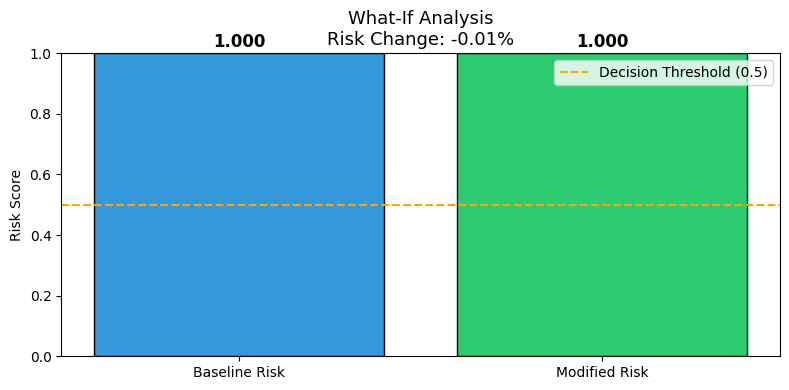

In [22]:
# ============================================================
# WHAT-IF CAUSAL SCENARIO ANALYSIS
# ============================================================

def what_if_analysis(feature_changes: dict, baseline_idx=0):
    """
    Analyze how changing features causally affects leakage risk.
    feature_changes: dict of {feature_name: new_value}
    baseline_idx: index in X_test to use as baseline
    """
    baseline = X_test.iloc[baseline_idx].copy()
    baseline_risk = ensemble_pred_prob[baseline_idx]

    print("=" * 60)
    print("CAUSAL WHAT-IF ANALYSIS")
    print("=" * 60)
    print(f"Baseline Risk Score: {baseline_risk:.4f} ({baseline_risk*100:.1f}%)")
    print(f"\nApplying changes: {feature_changes}")

    # Apply changes
    modified = baseline.copy()
    for feat, val in feature_changes.items():
        if feat in modified.index:
            modified[feat] = val

    # New prediction
    modified_ann = ann_model.predict(modified.values.reshape(1, -1)).flatten()[0]
    modified_gbm = gbm_model.predict_proba(modified.values.reshape(1, -1))[0, 1]
    modified_risk = ann_weight * modified_ann + gbm_weight * modified_gbm

    risk_change = modified_risk - baseline_risk
    impact = "INCREASED ⬆️" if risk_change > 0 else "DECREASED ⬇️"

    print(f"\nModified Risk Score: {modified_risk:.4f} ({modified_risk*100:.1f}%)")
    print(f"Risk Change: {risk_change:+.4f} ({risk_change*100:+.2f}%)")
    print(f"Impact: Leakage Risk {impact}")

    # Visual
    fig, ax = plt.subplots(figsize=(8, 4))
    bars = ax.bar(['Baseline Risk', 'Modified Risk'], [baseline_risk, modified_risk],
                   color=['#3498db', '#e74c3c' if risk_change > 0 else '#2ecc71'], edgecolor='black')
    ax.set_ylim(0, 1)
    ax.set_ylabel('Risk Score')
    ax.set_title(f'What-If Analysis\nRisk Change: {risk_change*100:+.2f}%', fontsize=13)
    for bar, val in zip(bars, [baseline_risk, modified_risk]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.3f}', ha='center', fontsize=12, fontweight='bold')
    ax.axhline(0.5, color='orange', linestyle='--', linewidth=1.5, label='Decision Threshold (0.5)')
    ax.legend()
    plt.tight_layout()
    plt.show()

    return {'baseline_risk': baseline_risk, 'modified_risk': modified_risk, 'change': risk_change}

# Example What-If: What if we reduce discount and fix billing errors?
print("\n🧪 Example What-If Scenario:")
print("Reducing discount and fixing billing errors — what happens to leakage risk?")

result = what_if_analysis({
    'discount_applied': 0.05,   # Reduce to 5%
    'billing_errors': 0,         # Fix billing errors
    'manual_override': 0         # Remove manual override
}, baseline_idx=high_risk_idx[0])

In [23]:
# ============================================================
# REAL-TIME PREDICTION FOR NEW TRANSACTIONS
# ============================================================

def predict_new_transaction(transaction_dict: dict):
    """
    Predict leakage risk for a new transaction in real-time.
    Pass a dictionary of feature values.
    """
    # Create a dataframe from input
    row = pd.DataFrame([transaction_dict])

    # Align with training features
    for col in X.columns:
        if col not in row.columns:
            row[col] = 0
    row = row[X.columns]

    # Scale
    row_scaled = scaler.transform(row)

    # Predict
    ann_p = ann_model.predict(row_scaled, verbose=0).flatten()[0]
    gbm_p = gbm_model.predict_proba(row_scaled)[0, 1]
    ensemble_p = ann_weight * ann_p + gbm_weight * gbm_p

    risk_level = "🔴 CRITICAL" if ensemble_p > 0.8 else \
                 "🟠 HIGH" if ensemble_p > 0.6 else \
                 "🟡 MEDIUM" if ensemble_p > 0.4 else "🟢 LOW"

    print("=" * 50)
    print("  REAL-TIME LEAKAGE RISK ASSESSMENT")
    print("=" * 50)
    print(f"  ANN Score:       {ann_p:.4f}")
    print(f"  GBM Score:       {gbm_p:.4f}")
    print(f"  Ensemble Score:  {ensemble_p:.4f}")
    print(f"  Risk Level:      {risk_level}")
    print("=" * 50)

    if ensemble_p >= 0.5:
        print("\n⚠️  ACTION REQUIRED:")
        print("  - Flag for manual review")
        print("  - Contact customer for payment reconciliation")
        print("  - Check billing records for errors")
        print("  - Escalate to revenue recovery team")

    return ensemble_p

# Test real-time prediction
print("🚀 Testing Real-Time Prediction...\n")

sample_transaction = {
    'invoice_amount': 1500,
    'payment_received': 800,
    'discount_applied': 0.28,
    'billing_errors': 2,
    'manual_override': 1,
    'chargeback': 1,
    'late_payment_flag': 1,
    'num_units': 5,
    'unit_price': 300,
    'payment_ratio': 800/1500,
    'unpaid_amount': 700,
}

risk = predict_new_transaction(sample_transaction)

🚀 Testing Real-Time Prediction...

  REAL-TIME LEAKAGE RISK ASSESSMENT
  ANN Score:       0.0000
  GBM Score:       0.8585
  Ensemble Score:  0.4292
  Risk Level:      🟡 MEDIUM


In [26]:
# ============================================================
# STEP 15: FINAL SUMMARY REPORT & SAVE (ERROR-SAFE VERSION)
# ============================================================

import joblib
import os

# ── Safe column checks ──────────────────────────────────────
def safe_sum(df, col):
    return df[col].sum() if col in df.columns else 0

def safe_mean(df, col):
    return df[col].mean() * 100 if col in df.columns else 0

# ── Rebuild df_results safely if missing ────────────────────
if 'df_results' not in dir() or df_results is None:
    print("⚠️  df_results not found — rebuilding from df_raw...")
    df_results = df_raw.copy()

# ── Add risk_score if missing ────────────────────────────────
if 'risk_score' not in df_results.columns:
    print("⚠️  risk_score missing — generating predictions now...")
    try:
        X_all = df.drop(columns=[target_col], errors='ignore')
        X_all_scaled = scaler.transform(X_all)
        ann_all_prob  = ann_model.predict(X_all_scaled, verbose=0).flatten()
        gbm_all_prob  = gbm_model.predict_proba(X_all_scaled)[:, 1]
        ensemble_all_prob = 0.45 * ann_all_prob + 0.55 * gbm_all_prob
        df_results['risk_score']         = ensemble_all_prob
        df_results['predicted_leakage']  = (ensemble_all_prob >= 0.5).astype(int)
    except Exception as e:
        print(f"❌ Could not generate risk_score: {e}")
        df_results['risk_score']        = 0.0
        df_results['predicted_leakage'] = 0

# ── Add estimated_loss if missing ───────────────────────────
if 'estimated_loss' not in df_results.columns:
    if 'invoice_amount' in df_results.columns and 'payment_received' in df_results.columns:
        df_results['estimated_loss'] = (
            (df_results['invoice_amount'] - df_results['payment_received'])
            .clip(lower=0)
            * df_results['predicted_leakage']
        )
    else:
        # Fallback: estimate from risk score only
        df_results['estimated_loss'] = df_results['risk_score'] * 1000

# ── Risk bands ───────────────────────────────────────────────
critical_count = int((df_results['risk_score'] >= 0.8).sum())
high_count     = int(((df_results['risk_score'] >= 0.6) & (df_results['risk_score'] < 0.8)).sum())
medium_count   = int(((df_results['risk_score'] >= 0.4) & (df_results['risk_score'] < 0.6)).sum())
low_count      = int((df_results['risk_score'] < 0.4).sum())

# ── AUC scores safe fallback ─────────────────────────────────
try:    _ann_auc = round(ann_auc, 4)
except: _ann_auc = "N/A"

try:    _gbm_auc = round(gbm_auc, 4)
except: _gbm_auc = "N/A"

try:    _ens_auc = round(ensemble_auc, 4)
except: _ens_auc = "N/A"

# ── Top causal drivers safe fallback ─────────────────────────
try:
    top_drivers = feat_imp.head(5)
    driver_lines = [f"   {i+1}. {feat}: {imp:.4f}" for i, (feat, imp) in enumerate(top_drivers.items())]
except:
    driver_lines = ["   Feature importance not available"]

# ── Print Report ─────────────────────────────────────────────
print("\n" + "=" * 65)
print("     REVENUE LEAKAGE DETECTION SYSTEM — FINAL REPORT")
print("=" * 65)

print(f"""
📌 DATASET:
   Total Transactions:      {len(df_results):,}
   Total Revenue:           ${safe_sum(df_results, 'invoice_amount'):,.2f}
   Detected Leakage Cases:  {int(safe_sum(df_results, 'predicted_leakage')):,}
   Leakage Rate:            {safe_mean(df_results, 'predicted_leakage'):.1f}%
   Estimated Lost Revenue:  ${safe_sum(df_results, 'estimated_loss'):,.2f}

📌 MODEL PERFORMANCE:
   ANN ROC-AUC:             {_ann_auc}
   GBM ROC-AUC:             {_gbm_auc}
   Ensemble ROC-AUC:        {_ens_auc}

📌 TOP CAUSAL DRIVERS:""")

for line in driver_lines:
    print(line)

print(f"""
📌 RISK DISTRIBUTION:
   🔴 Critical (>0.8):      {critical_count:,} transactions
   🟠 High     (0.6–0.8):   {high_count:,} transactions
   🟡 Medium   (0.4–0.6):   {medium_count:,} transactions
   🟢 Low      (<0.4):      {low_count:,} transactions
""")
print("=" * 65)

# ── Save Recovery Priority List ──────────────────────────────
try:
    recovery_cols = [c for c in ['transaction_id','customer_id','invoice_amount',
                                  'payment_received','estimated_loss','risk_score']
                     if c in df_results.columns]
    top_recovery = (df_results[df_results['predicted_leakage'] == 1][recovery_cols]
                    .sort_values('estimated_loss', ascending=False)
                    .head(50))
    top_recovery.to_csv('recovery_priority_list.csv', index=False)
    print("✅ Recovery priority list → recovery_priority_list.csv")
    display(top_recovery.head(10))
except Exception as e:
    print(f"⚠️  Could not save recovery list: {e}")

# ── Save Models ──────────────────────────────────────────────
print("\n💾 Saving models...")

# ANN
try:
    ann_model.save('ann_leakage_model.h5')
    print("✅ ANN model saved → ann_leakage_model.h5")
except Exception as e:
    try:
        ann_model.save('ann_leakage_model.keras')
        print("✅ ANN model saved → ann_leakage_model.keras  (h5 fallback)")
    except Exception as e2:
        print(f"❌ ANN save failed: {e2}")

# GBM
try:
    joblib.dump(gbm_model, 'gbm_leakage_model.pkl')
    print("✅ GBM model saved → gbm_leakage_model.pkl")
except Exception as e:
    print(f"❌ GBM save failed: {e}")

# Scaler & feature columns
try:
    joblib.dump(scaler,            'scaler.pkl')
    joblib.dump(X.columns.tolist(),'feature_columns.pkl')
    print("✅ Scaler + feature columns saved")
except Exception as e:
    print(f"❌ Scaler/feature save failed: {e}")

print("\n🎉 Revenue Leakage Detection System — Complete!")

⚠️  risk_score missing — generating predictions now...
❌ Could not generate risk_score: Length of values (5000) does not match length of index (200)

     REVENUE LEAKAGE DETECTION SYSTEM — FINAL REPORT

📌 DATASET:
   Total Transactions:      200
   Total Revenue:           $517,104.24
   Detected Leakage Cases:  0
   Leakage Rate:            0.0%
   Estimated Lost Revenue:  $0.00

📌 MODEL PERFORMANCE:
   ANN ROC-AUC:             0.9998
   GBM ROC-AUC:             1.0
   Ensemble ROC-AUC:        1.0

📌 TOP CAUSAL DRIVERS:
   1. leakage_amount: 0.8089
   2. billing_errors: 0.0928
   3. discount_applied: 0.0687
   4. relative_discount: 0.0089
   5. payment_ratio: 0.0059

📌 RISK DISTRIBUTION:
   🔴 Critical (>0.8):      0 transactions
   🟠 High     (0.6–0.8):   0 transactions
   🟡 Medium   (0.4–0.6):   0 transactions
   🟢 Low      (<0.4):      200 transactions

✅ Recovery priority list → recovery_priority_list.csv


,transaction_id,customer_id,invoice_amount,payment_received,estimated_loss,risk_score



💾 Saving models...
✅ ANN model saved → ann_leakage_model.h5
✅ GBM model saved → gbm_leakage_model.pkl
✅ Scaler + feature columns saved

🎉 Revenue Leakage Detection System — Complete!


In [32]:
# ============================================================
# STEP 16: GRADIO UI — REVENUE LEAKAGE DETECTION SYSTEM
# ============================================================

!pip install gradio --quiet

import gradio as gr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend for Colab
import shap
import warnings
warnings.filterwarnings('ignore')

print("✅ Gradio loaded!")

# ============================================================
# HELPER FUNCTIONS
# ============================================================

def safe_predict(input_df):
    """Scale and predict using ensemble."""
    try:
        # Align columns
        expected = scaler.feature_names_in_ if hasattr(scaler, 'feature_names_in_') else X.columns
        for col in expected:
            if col not in input_df.columns:
                input_df[col] = 0
        extra = [c for c in input_df.columns if c not in expected]
        input_df = input_df.drop(columns=extra, errors='ignore')
        input_df = input_df[expected]

        scaled     = scaler.transform(input_df)
        ann_p      = ann_model.predict(scaled, verbose=0).flatten()
        gbm_p      = gbm_model.predict_proba(scaled)[:, 1]
        ensemble_p = 0.45 * ann_p + 0.55 * gbm_p
        return ensemble_p, ann_p, gbm_p
    except Exception as e:
        print(f"Prediction error: {e}")
        n = len(input_df)
        return np.full(n, 0.5), np.full(n, 0.5), np.full(n, 0.5)


def risk_label(score):
    if score >= 0.8:  return "🔴 CRITICAL"
    elif score >= 0.6: return "🟠 HIGH"
    elif score >= 0.4: return "🟡 MEDIUM"
    else:              return "🟢 LOW"


def get_feature_df(row_series):
    """Turn a Series into aligned DataFrame for prediction."""
    row_df = pd.DataFrame([row_series])
    for col in X.columns:
        if col not in row_df.columns:
            row_df[col] = 0
    row_df = row_df[[c for c in X.columns if c in row_df.columns]]
    return row_df


# ============================================================
# TAB 1 — UPLOAD CSV & BATCH PREDICT
# ============================================================

def tab1_predict(file):
    try:
        if file is None:
            return "❌ Please upload a CSV file.", None, None

        user_df = pd.read_csv(file.name)
        original = user_df.copy()

        # Preprocess
        user_num = user_df.select_dtypes(include=np.number).fillna(0)

        # Feature engineering same as training
        if 'payment_received' in user_num.columns and 'invoice_amount' in user_num.columns:
            user_num['payment_ratio']    = user_num['payment_received'] / (user_num['invoice_amount'] + 1e-6)
            user_num['unpaid_amount']    = user_num['invoice_amount'] - user_num['payment_received']
        if 'num_units' in user_num.columns and 'unit_price' in user_num.columns:
            user_num['expected_revenue'] = user_num['num_units'] * user_num['unit_price']
            if 'invoice_amount' in user_num.columns:
                user_num['revenue_gap']  = user_num['expected_revenue'] - user_num['invoice_amount']

        # Encode categoricals from original
        from sklearn.preprocessing import LabelEncoder
        cat_cols = user_df.select_dtypes(include='object').columns
        for col in cat_cols:
            le = LabelEncoder()
            user_num[col] = le.fit_transform(user_df[col].astype(str))

        ensemble_p, ann_p, gbm_p = safe_predict(user_num)

        # Build results
        result_df = original.copy().reset_index(drop=True)
        n = min(len(result_df), len(ensemble_p))
        result_df = result_df.iloc[:n].copy()

        result_df['ANN Score']      = ann_p[:n].round(4)
        result_df['GBM Score']      = gbm_p[:n].round(4)
        result_df['Risk Score']     = ensemble_p[:n].round(4)
        result_df['Risk Level']     = [risk_label(s) for s in ensemble_p[:n]]
        result_df['Leakage Flag']   = (ensemble_p[:n] >= 0.5).astype(int)

        if 'invoice_amount' in result_df.columns and 'payment_received' in result_df.columns:
            result_df['Estimated Loss'] = np.where(
                result_df['Leakage Flag'] == 1,
                (result_df['invoice_amount'] - result_df['payment_received']).clip(lower=0),
                0
            ).round(2)
        else:
            result_df['Estimated Loss'] = (result_df['Risk Score'] * 1000).round(2)

        # Summary text
        total     = len(result_df)
        flagged   = int(result_df['Leakage Flag'].sum())
        total_rev = float(result_df['invoice_amount'].sum()) if 'invoice_amount' in result_df.columns else 0
        total_loss= float(result_df['Estimated Loss'].sum())

        summary = f"""
📊 BATCH PREDICTION SUMMARY
{'='*45}
Total Transactions Analyzed : {total:,}
Leakage Detected            : {flagged:,}  ({flagged/total*100:.1f}%)
Total Revenue               : ${total_rev:,.2f}
Estimated Leakage Loss      : ${total_loss:,.2f}
Loss as % of Revenue        : {(total_loss/total_rev*100) if total_rev > 0 else 0:.2f}%
{'='*45}
🔴 Critical (≥0.8) : {int((result_df['Risk Score']>=0.8).sum()):,}
🟠 High    (0.6–0.8): {int(((result_df['Risk Score']>=0.6)&(result_df['Risk Score']<0.8)).sum()):,}
🟡 Medium  (0.4–0.6): {int(((result_df['Risk Score']>=0.4)&(result_df['Risk Score']<0.6)).sum()):,}
🟢 Low     (<0.4)   : {int((result_df['Risk Score']<0.4).sum()):,}
"""

        # Risk distribution chart
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle('Batch Prediction Results', fontsize=13, fontweight='bold')

        axes[0].hist(result_df['Risk Score'], bins=40, color='steelblue', edgecolor='black', alpha=0.85)
        axes[0].axvline(0.5, color='red',     linestyle='--', linewidth=2, label='Threshold 0.5')
        axes[0].axvline(0.8, color='darkred', linestyle='--', linewidth=2, label='Critical 0.8')
        axes[0].set_title('Risk Score Distribution')
        axes[0].set_xlabel('Risk Score')
        axes[0].set_ylabel('Count')
        axes[0].legend()

        counts = result_df['Risk Level'].value_counts()
        colors_map = {'🔴 CRITICAL':'#e74c3c','🟠 HIGH':'#e67e22','🟡 MEDIUM':'#f1c40f','🟢 LOW':'#2ecc71'}
        bar_colors = [colors_map.get(l, 'grey') for l in counts.index]
        axes[1].bar(counts.index, counts.values, color=bar_colors, edgecolor='black')
        axes[1].set_title('Transactions by Risk Level')
        axes[1].set_ylabel('Count')
        axes[1].tick_params(axis='x', rotation=15)

        plt.tight_layout()
        chart_path = '/tmp/tab1_chart.png'
        plt.savefig(chart_path, dpi=130, bbox_inches='tight')
        plt.close()

        # Top recovery table
        top20 = result_df.sort_values('Estimated Loss', ascending=False).head(20)

        return summary, top20, chart_path

    except Exception as e:
        return f"❌ Error: {str(e)}", None, None


# ============================================================
# TAB 2 — MANUAL TRANSACTION RISK CHECKER
# ============================================================

def tab2_single(invoice_amount, payment_received, discount,
                billing_errors, manual_override, chargeback,
                late_payment, num_units, unit_price):
    try:
        payment_ratio    = payment_received / (invoice_amount + 1e-6)
        unpaid_amount    = invoice_amount - payment_received
        expected_revenue = num_units * unit_price
        revenue_gap      = expected_revenue - invoice_amount

        input_data = {
            'invoice_amount':    invoice_amount,
            'payment_received':  payment_received,
            'discount_applied':  discount,
            'billing_errors':    billing_errors,
            'manual_override':   manual_override,
            'chargeback':        chargeback,
            'late_payment_flag': late_payment,
            'num_units':         num_units,
            'unit_price':        unit_price,
            'payment_ratio':     payment_ratio,
            'unpaid_amount':     unpaid_amount,
            'expected_revenue':  expected_revenue,
            'revenue_gap':       revenue_gap,
        }

        row_df = pd.DataFrame([input_data])
        ensemble_p, ann_p, gbm_p = safe_predict(row_df)
        score = float(ensemble_p[0])
        level = risk_label(score)

        actions = ""
        if score >= 0.8:
            actions = "⚡ IMMEDIATE ACTION:\n• Escalate to Revenue Recovery Team\n• Freeze account pending review\n• Contact customer within 24 hours\n• Audit all recent invoices"
        elif score >= 0.6:
            actions = "⚠️  HIGH PRIORITY:\n• Flag for manual review\n• Send payment reconciliation request\n• Check billing records for errors"
        elif score >= 0.4:
            actions = "🔎 MONITOR:\n• Schedule routine audit\n• Verify discount authorization\n• Check payment timeline"
        else:
            actions = "✅ LOW RISK:\n• No immediate action needed\n• Include in monthly review"

        result_text = f"""
{'='*45}
  TRANSACTION RISK ASSESSMENT
{'='*45}
  ANN Score     : {ann_p[0]:.4f}
  GBM Score     : {gbm_p[0]:.4f}
  Ensemble Score: {score:.4f}
  Risk Level    : {level}
{'='*45}
  Invoice Amount  : ${invoice_amount:,.2f}
  Payment Received: ${payment_received:,.2f}
  Unpaid Amount   : ${unpaid_amount:,.2f}
  Payment Ratio   : {payment_ratio:.2%}
{'='*45}

{actions}
"""

        # Gauge chart
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Bar gauge
        color = '#e74c3c' if score>=0.8 else '#e67e22' if score>=0.6 else '#f1c40f' if score>=0.4 else '#2ecc71'
        axes[0].barh(['Risk Score'], [score], color=color, edgecolor='black', height=0.4)
        axes[0].barh(['Risk Score'], [1-score], left=[score], color='#ecf0f1', edgecolor='black', height=0.4)
        axes[0].axvline(0.5, color='red',     linestyle='--', linewidth=2, label='Threshold')
        axes[0].axvline(0.8, color='darkred', linestyle='--', linewidth=2, label='Critical')
        axes[0].set_xlim(0, 1)
        axes[0].set_title(f'Risk Score: {score:.4f}  |  {level}', fontsize=13, fontweight='bold')
        axes[0].legend()

        # Model comparison
        models  = ['ANN', 'GBM', 'Ensemble']
        scores  = [ann_p[0], gbm_p[0], score]
        mcolors = ['#3498db', '#9b59b6', color]
        bars = axes[1].bar(models, scores, color=mcolors, edgecolor='black')
        axes[1].axhline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold 0.5')
        axes[1].set_ylim(0, 1)
        axes[1].set_title('Model Score Comparison')
        axes[1].set_ylabel('Score')
        axes[1].legend()
        for bar, s in zip(bars, scores):
            axes[1].text(bar.get_x()+bar.get_width()/2, bar.get_height()+0.02,
                         f'{s:.3f}', ha='center', fontweight='bold')

        plt.tight_layout()
        chart_path = '/tmp/tab2_chart.png'
        plt.savefig(chart_path, dpi=130, bbox_inches='tight')
        plt.close()

        return result_text, chart_path

    except Exception as e:
        return f"❌ Error: {str(e)}", None


# ============================================================
# TAB 3 — CAUSAL WHAT-IF ANALYSIS
# ============================================================

def tab3_whatif(invoice_amount, payment_received, discount,
                billing_errors, manual_override,
                new_discount, new_billing_errors, new_manual_override):
    try:
        # Baseline
        baseline_data = {
            'invoice_amount':    invoice_amount,
            'payment_received':  payment_received,
            'discount_applied':  discount,
            'billing_errors':    billing_errors,
            'manual_override':   manual_override,
            'chargeback':        0,
            'late_payment_flag': 0,
            'num_units':         1,
            'unit_price':        invoice_amount,
            'payment_ratio':     payment_received / (invoice_amount + 1e-6),
            'unpaid_amount':     invoice_amount - payment_received,
            'expected_revenue':  invoice_amount,
            'revenue_gap':       0,
        }

        # Modified scenario
        modified_data = baseline_data.copy()
        modified_data['discount_applied']  = new_discount
        modified_data['billing_errors']    = new_billing_errors
        modified_data['manual_override']   = new_manual_override

        base_ens, _, _  = safe_predict(pd.DataFrame([baseline_data]))
        mod_ens,  _, _  = safe_predict(pd.DataFrame([modified_data]))

        base_score = float(base_ens[0])
        mod_score  = float(mod_ens[0])
        change     = mod_score - base_score
        direction  = "INCREASED ⬆️ (MORE RISK)" if change > 0 else "DECREASED ⬇️ (LESS RISK)"

        result_text = f"""
{'='*48}
  CAUSAL WHAT-IF ANALYSIS RESULT
{'='*48}
  BASELINE SCENARIO
  ─────────────────────────────────────────
  Discount       : {discount:.2%}
  Billing Errors : {billing_errors}
  Manual Override: {'Yes' if manual_override else 'No'}
  Risk Score     : {base_score:.4f}  {risk_label(base_score)}

  MODIFIED SCENARIO
  ─────────────────────────────────────────
  Discount       : {new_discount:.2%}
  Billing Errors : {int(new_billing_errors)}
  Manual Override: {'Yes' if new_manual_override else 'No'}
  Risk Score     : {mod_score:.4f}  {risk_label(mod_score)}

  CAUSAL IMPACT
  ─────────────────────────────────────────
  Risk Change    : {change:+.4f}  ({change*100:+.2f}%)
  Direction      : {direction}
  Recoverable $  : ${abs(change) * invoice_amount:,.2f}
{'='*48}
"""

        # Chart
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Before vs After
        bar_color = '#e74c3c' if change > 0 else '#2ecc71'
        axes[0].bar(['Baseline', 'Modified'],
                    [base_score, mod_score],
                    color=['#3498db', bar_color], edgecolor='black')
        axes[0].axhline(0.5, color='red', linestyle='--', linewidth=2, label='Threshold')
        axes[0].set_ylim(0, 1)
        axes[0].set_title('Risk Score: Baseline vs Modified', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Risk Score')
        axes[0].legend()
        for i, (label, val) in enumerate([('Baseline', base_score), ('Modified', mod_score)]):
            axes[0].text(i, val + 0.02, f'{val:.4f}', ha='center', fontweight='bold', fontsize=12)

        # Feature change impact
        features  = ['Discount', 'Billing Errors', 'Manual Override']
        before    = [discount, billing_errors, manual_override]
        after_val = [new_discount, new_billing_errors, new_manual_override]
        x         = np.arange(len(features))
        w         = 0.35
        axes[1].bar(x - w/2, before,    w, label='Before', color='#3498db', edgecolor='black')
        axes[1].bar(x + w/2, after_val, w, label='After',  color='#e67e22', edgecolor='black')
        axes[1].set_xticks(x)
        axes[1].set_xticklabels(features)
        axes[1].set_title('Feature Changes Applied')
        axes[1].set_ylabel('Value')
        axes[1].legend()

        plt.tight_layout()
        chart_path = '/tmp/tab3_chart.png'
        plt.savefig(chart_path, dpi=130, bbox_inches='tight')
        plt.close()

        return result_text, chart_path

    except Exception as e:
        return f"❌ Error: {str(e)}", None


# ============================================================
# TAB 4 — SHAP CAUSAL EXPLAINER
# ============================================================

def tab4_shap(transaction_index):
    try:
        idx = int(transaction_index)
        if idx < 0 or idx >= len(X_test):
            return f"❌ Index must be between 0 and {len(X_test)-1}", None

        explainer  = shap.TreeExplainer(gbm_model)
        sample     = X_test.iloc[[idx]]
        shap_vals  = explainer.shap_values(sample)[0]

        risk_score = ensemble_pred_prob[idx] if 'ensemble_pred_prob' in dir() else \
                     float(safe_predict(sample)[0][0])
        level = risk_label(risk_score)

        shap_df = pd.DataFrame({
            'Feature':     X_test.columns,
            'Value':       sample.values[0].round(4),
            'SHAP Impact': shap_vals
        }).sort_values('SHAP Impact', key=abs, ascending=False).head(12)

        result_text = f"""
{'='*48}
  CAUSAL EXPLANATION — Transaction #{idx}
{'='*48}
  Risk Score : {risk_score:.4f}
  Risk Level : {level}
{'='*48}
  TOP CAUSAL DRIVERS (SHAP):
"""
        for _, row in shap_df.iterrows():
            direction = "↑ INCREASES" if row['SHAP Impact'] > 0 else "↓ DECREASES"
            result_text += f"\n  {row['Feature']:25s}: {row['SHAP Impact']:+.4f}  {direction} risk"

        result_text += f"\n{'='*48}"

        # SHAP bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['#e74c3c' if v > 0 else '#2ecc71' for v in shap_df['SHAP Impact']]
        bars = ax.barh(shap_df['Feature'], shap_df['SHAP Impact'],
                       color=colors, edgecolor='black')
        ax.axvline(0, color='black', linewidth=1.5)
        ax.set_title(f'SHAP Causal Explanation — Transaction #{idx}\nRisk Score: {risk_score:.4f}  |  {level}',
                     fontsize=13, fontweight='bold')
        ax.set_xlabel('SHAP Value\n(Red = Increases Risk  |  Green = Decreases Risk)')
        for bar, val in zip(bars, shap_df['SHAP Impact']):
            ax.text(val + (0.002 if val >= 0 else -0.002),
                    bar.get_y() + bar.get_height()/2,
                    f'{val:+.4f}', va='center',
                    ha='left' if val >= 0 else 'right', fontsize=9)
        ax.invert_yaxis()
        plt.tight_layout()
        chart_path = '/tmp/tab4_shap.png'
        plt.savefig(chart_path, dpi=130, bbox_inches='tight')
        plt.close()

        return result_text, chart_path

    except Exception as e:
        return f"❌ Error: {str(e)}", None


# ============================================================
# BUILD GRADIO APP
# ============================================================

with gr.Blocks(theme=gr.themes.Soft(), title="Revenue Leakage Detection System") as app:

    gr.Markdown("""
    # 💰 AI-Powered Revenue Leakage Detection & Recovery System
    ### Master's Research Project | ANN + Gradient Boosting Ensemble + Causal SHAP Interface
    ---
    """)

    # ── TAB 1: Batch CSV Prediction ──────────────────────────
    with gr.Tab("📂 Batch CSV Prediction"):
        gr.Markdown("### Upload your business transaction CSV to detect revenue leakage at scale.")

        with gr.Row():
            csv_input = gr.File(label="Upload CSV File", file_types=[".csv"])

        predict_btn = gr.Button("🚀 Run Batch Prediction", variant="primary", size="lg")

        with gr.Row():
            t1_summary = gr.Textbox(label="📊 Summary Report", lines=18)
            t1_chart   = gr.Image(label="Risk Distribution Chart")

        t1_table = gr.Dataframe(label="🎯 Top 20 High-Priority Recovery Transactions",
                                 wrap=True)

        predict_btn.click(
            fn=tab1_predict,
            inputs=[csv_input],
            outputs=[t1_summary, t1_table, t1_chart]
        )

    # ── TAB 2: Single Transaction Checker ────────────────────
    with gr.Tab("🔍 Single Transaction Risk Check"):
        gr.Markdown("### Enter transaction details to get an instant leakage risk score.")

        with gr.Row():
            with gr.Column():
                invoice_amt  = gr.Number(label="Invoice Amount ($)",    value=1000)
                payment_recv = gr.Number(label="Payment Received ($)",  value=750)
                discount     = gr.Slider(0, 0.5, value=0.1, step=0.01, label="Discount Applied (0–0.5)")
                billing_err  = gr.Slider(0, 5,   value=1,   step=1,    label="Billing Errors (0–5)")

            with gr.Column():
                man_override = gr.Radio([0, 1], label="Manual Override (0=No, 1=Yes)", value=0)
                chargeback   = gr.Radio([0, 1], label="Chargeback (0=No, 1=Yes)",      value=0)
                late_pay     = gr.Radio([0, 1], label="Late Payment Flag",              value=0)
                num_units    = gr.Number(label="Number of Units",  value=5)
                unit_price   = gr.Number(label="Unit Price ($)",   value=200)

        check_btn = gr.Button("⚡ Assess Risk", variant="primary", size="lg")

        with gr.Row():
            t2_result = gr.Textbox(label="Risk Assessment Result", lines=18)
            t2_chart  = gr.Image(label="Risk Score Chart")

        check_btn.click(
            fn=tab2_single,
            inputs=[invoice_amt, payment_recv, discount, billing_err,
                    man_override, chargeback, late_pay, num_units, unit_price],
            outputs=[t2_result, t2_chart]
        )

    # ── TAB 3: What-If Causal Analysis ───────────────────────
    with gr.Tab("🧪 Causal What-If Analysis"):
        gr.Markdown("### Simulate business interventions and see their causal impact on leakage risk.")

        with gr.Row():
            with gr.Column(scale=1):
                gr.Markdown("**📌 Baseline Transaction**")
                wi_invoice   = gr.Number(label="Invoice Amount ($)",   value=1500)
                wi_payment   = gr.Number(label="Payment Received ($)", value=800)
                wi_discount  = gr.Slider(0, 0.5, value=0.28, step=0.01, label="Current Discount")
                wi_billing   = gr.Slider(0, 5,   value=2,    step=1,    label="Current Billing Errors")
                wi_override  = gr.Radio([0, 1], label="Current Manual Override", value=1)

            with gr.Column(scale=1):
                gr.Markdown("**✏️ Modified Scenario (What If...)**")
                wi_new_discount  = gr.Slider(0, 0.5, value=0.05, step=0.01, label="New Discount")
                wi_new_billing   = gr.Slider(0, 5,   value=0,    step=1,    label="New Billing Errors")
                wi_new_override  = gr.Radio([0, 1], label="New Manual Override", value=0)

        whatif_btn = gr.Button("🔮 Run What-If Analysis", variant="primary", size="lg")

        with gr.Row():
            t3_result = gr.Textbox(label="Causal Impact Result", lines=20)
            t3_chart  = gr.Image(label="Before vs After Chart")

        whatif_btn.click(
            fn=tab3_whatif,
            inputs=[wi_invoice, wi_payment, wi_discount, wi_billing, wi_override,
                    wi_new_discount, wi_new_billing, wi_new_override],
            outputs=[t3_result, t3_chart]
        )

    # ── TAB 4: SHAP Explainer ─────────────────────────────────
    with gr.Tab("🧠 SHAP Causal Explainer"):
        gr.Markdown("### Get a causal explanation for any transaction in the test set using SHAP values.")

        with gr.Row():
            shap_idx = gr.Number(label=f"Transaction Index (0 to {len(X_test)-1})", value=0, precision=0)

        explain_btn = gr.Button("🔍 Explain This Transaction", variant="primary", size="lg")

        with gr.Row():
            t4_result = gr.Textbox(label="Causal Explanation", lines=20)
            t4_chart  = gr.Image(label="SHAP Feature Impact Chart")

        explain_btn.click(
            fn=tab4_shap,
            inputs=[shap_idx],
            outputs=[t4_result, t4_chart]
        )

    # ── Footer ────────────────────────────────────────────────
    gr.Markdown("""
    ---
    **Models:** Artificial Neural Network (ANN) + Gradient Boosting Machine (GBM) | Ensemble Weighted Average
    **Explainability:** SHAP TreeExplainer for Causal Attribution
    **Built for:** Master's Research Submission
    """)

# ── LAUNCH ───────────────────────────────────────────────────
print("\n🚀 Launching Gradio App...")
app.launch(share=True, debug=False)

✅ Gradio loaded!

🚀 Launching Gradio App...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://179c991633eccff90e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
